- Reference Code
1. https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb
2. https://github.com/aespresso/a_journey_into_math_of_ml/blob/master/03_transformer_tutorial_1st_part/BERT_tutorial_and_attention_visualization/models/bert_model.py
- Also referred to Hungyi-Lee's HW8 structure: https://colab.research.google.com/drive/11iwJbQv9iScRo6kGP7YfyHaaorlHhzMT

- Please remember to change model paths and lib paths!!

![model_structure.png](https://i.loli.net/2020/07/14/FP5B89Esv3uiJkL.png)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms
import gensim

import numpy as np
import math
import random
import json
import pickle

import matplotlib as plt
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from matplotlib.font_manager import *  
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import sys
import os
sys.path.append("..")
sys.path.append("/data_loader") #Please change the path for your environment
from data_loader.Nottingham_database_preprocessor import *
from data_loader.Nottingham_database_preprocessor_util import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
%matplotlib inline

cpu


### Overall configurations

In [ ]:
class configurations(object):
    def __init__(self):
        self.batch_size = 1
        self.emb_dim = 64 # make sure that emb_dim/num_heads is an integer!
        self.splitted_dim_list = [16,2,46]
        self.class_dim = self.splitted_dim_list[0]+self.splitted_dim_list[1]

        self.class_contents_int2class = {0:'controller',1:'4/4',2:'2/2',3:'3/4',4:'6/8',5:'5/4',6:'3/2',7:'2/4',8:'9/8',9:'12/8',10:'12/16',11:'6/4',12:'others'}
        self.class_contents_class2int = {value:key for key, value in self.class_contents_int2class.items()}
        self.grouping_int2class = {0:'controller',1:'binary',2:'ternary',3:'quintet',4:'others'}
        self.grouping_class2int = {value:key for key, value in self.grouping_int2class.items()}
        self.binary_list = ['4/4','2/2','6/8','2/4','12/8','12/16']
        self.ternary_list = ['3/4','3/2','9/8','6/4']
        self.quintet_list = ['5/4','5/2','5/8']
        
        self.classifier_out_len_list = [len(self.class_contents_int2class),len(self.grouping_int2class)]
        self.n_layers = 6 #6
        self.num_heads = 8 #8
        self.dropout = 0.5
        self.ffn_dim = 1024
        self.learning_rate = 0.0001
        self.max_output_len = 800
        self.num_steps = 20000
        self.store_steps = 4000
        self.summary_steps = 1000
        self.mask_prob = 0.2 #0.5
        self.head_len = 10
        self.bias_tokens_n = 20
        self.vq_vocab_size_factor = 5
        self.sampling = True
        self.load_model = False
        self.store_model_path = "/" #Please change the path for your environment
        self.load_model_path = "/model_"+str(self.num_steps) #Please change the path for your environment
        self.data_path = "/data_folder/" #Please change the path for your environment

config = configurations()
embedding_tensor = None

### Dataset and preprocessing

- Dictionary controllers: {$1:'<PAD>',2:'<BOS>',3:'<EOS>',4:'<UNK>',5:'<MASK>',6:'<CLS>'$}, position_bias=20

In [ ]:
class LabelTransform(object):
    def __init__(self, size, pad):
        self.size = size
        self.pad = pad

    def __call__(self, label):
        label = np.pad(label, (0, (self.size - label.shape[0])), mode='constant', constant_values=self.pad)
        return label

def infinite_iter(data_loader):
    it = iter(data_loader)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(data_loader)

def jsonKeys2int(x):
    if isinstance(x, dict):
        return {int(k):v for k,v in x.items()}
    return x

class RhythmDataset(data.Dataset):
    def __init__(self, config, set_name, pad=False):
        self.root = config.data_path
        self.max_output_len = config.max_output_len
        self.word2int, self.int2word = self.get_dictionary()
        self.max_id = max(self.int2word)
        print('max index in dict is ',self.max_id)

        self.dict_size = len(self.word2int)
        self.vocab_size = self.max_id+1
        self.data = []
        self.data_class = []
        self.data_grouping = []
        self.data_freq = []
        self.data_sample_weight = []
        self.data_meter_freq = []
        self.data_meter_weight = []
        with open(os.path.join(self.root, f'{set_name}'), "rb") as f:
            self.data=pickle.load(f)
            print (f'{set_name} dataset size: {len(self.data)}')
        
        self.word2freq, self.int2freq = self.get_word_freq()
        self.get_data_freq_and_weight()

        self.class_contents_int2class = config.class_contents_int2class
        self.class_contents_class2int = config.class_contents_class2int
        self.meter2freq = {}
        self.grouping_int2class = config.grouping_int2class
        self.grouping_class2int = config.grouping_class2int
        self.binary_list = config.binary_list
        self.ternary_list = config.ternary_list
        self.quintet_list = config.quintet_list

        self.word_idx2meter_idx = {}
        self.word_idx2grouping_idx = {}

        self.get_contents_and_grouping_dictionary()
        self.align_classes_for_data()
        
        self.pad = pad
        self.mask_prob = config.mask_prob
        self.generate_mode = False
        self.bias_tokens_n = config.bias_tokens_n
        self.head_len = config.head_len
        self.transform = LabelTransform(self.max_output_len, self.word2int['<PAD>'])
        self.transform_class = LabelTransform(self.max_output_len, 0)

    def get_dictionary(self):
        with open(os.path.join(self.root+'/rhythm_dict', f'vocab_word2int.json'), "r") as f:
            word2int = json.load(f)
        with open(os.path.join(self.root+'/rhythm_dict', f'vocab_int2word.json'), "r") as f:
            int2word = json.load(f, object_hook=jsonKeys2int)
        return word2int, int2word

    def get_word_freq(self):
        word2freq = {}
        int2freq = {}
        for index in self.int2word:
            int2freq.update({index:0})
            word2freq.update({self.int2word[index]:0})
        for sen in self.data:
            for word in sen:
                this_word_id = self.word2int[word]
                int2freq[this_word_id] += 1
                word2freq[word] += 1
        return word2freq, int2freq

    def get_data_freq_and_weight(self,var_factor = 0.5):
        self.data_freq = []
        self.data_sample_weight = []
        for sen in self.data:
            this_freq = 0
            this_len = len(sen)
            for word in sen:
                this_freq += self.word2freq[word]/this_len
            self.data_freq.append(this_freq)
        ave_freq = sum(self.data_freq)/len(self.data)
        for fre in self.data_freq:
            this_w = math.exp(-1*var_factor*(fre/ave_freq))
            self.data_sample_weight.append(this_w)
        sum_w = sum(self.data_sample_weight)
        for i,fre in enumerate(self.data_sample_weight):
            self.data_sample_weight[i] = fre/sum_w*len(self.data)

    def class_str2grouping_idx(self,class_str):
        if class_str == 'controller':
            return 0
        elif class_str in self.binary_list:
            return self.grouping_class2int['binary']
        elif class_str in self.ternary_list:
            return self.grouping_class2int['ternary']
        elif class_str in self.quintet_list:
            return self.grouping_class2int['quintet']
        else:
            return self.grouping_class2int['others']
    
    def class_idx2grouping_idx(self,class_idx):
        class_str = self.class_contents_int2class[class_idx]
        return self.class_str2grouping_idx(class_str)

    def get_contents_and_grouping_dictionary(self):
        last_index = len(self.class_contents_int2class)-1
        for index in range(self.vocab_size):
            if index not in self.int2word:
                self.word_idx2meter_idx.update({index:last_index})             
                continue
            else:
                find_flag = 0
                for index_meter in self.class_contents_int2class:
                    this_class = self.class_contents_int2class[index_meter]
                    word = self.int2word[index]
                    if this_class in word:
                        self.word_idx2meter_idx.update({index:index_meter})
                        find_flag = 1
                        break
                if not find_flag:
                    self.word_idx2meter_idx.update({index:0})
            
            this_grouping = self.class_idx2grouping_idx(self.word_idx2meter_idx[index])
            self.word_idx2grouping_idx.update({index:this_grouping})

    def align_classes_for_data(self,var_factor=2):
        self.data_meter = []
        self.data_grouping = []
        self.data_meter_freq = []
        for sen in self.data:
            this_sen_meter = []
            this_sen_grouping = []
            for word in sen:
                this_word_id = self.word2int[word]
                this_word_meter = self.word_idx2meter_idx[this_word_id]
                this_word_grouping = self.word_idx2grouping_idx[this_word_id]
                this_sen_meter.append(this_word_meter)
                this_sen_grouping.append(this_word_grouping)
            self.data_meter.append(this_sen_meter)
            self.data_grouping.append(this_sen_grouping)
            if this_sen_meter[1] not in self.meter2freq:
                self.meter2freq.update({this_sen_meter[1]:1})
            else:
                self.meter2freq[this_sen_meter[1]] += 1
        for id,met in enumerate(self.data_meter):
            this_meter_id = met[1]
            self.data_meter_freq.append(self.meter2freq[this_meter_id])
        ave_freq = sum(self.data_meter_freq)/len(self.data)
        for fre in self.data_meter_freq:
            this_w = math.exp(-1*var_factor*(fre/ave_freq))
            self.data_meter_weight.append(this_w)
        sum_w = sum(self.data_sample_weight)
        for i,fre in enumerate(self.data_meter_weight):
            self.data_meter_weight[i] = fre/sum_w*len(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, Index):
        global device
        sentence = self.data[Index]
        sentence_meter = self.data_meter[Index]
        sentence_grouping = self.data_grouping[Index]
        sentence_idx = []
        target = []
        masked_pos = []
        word_freq = []
        for index,word in enumerate(sentence):
            word_sen = word
            if self.mask_prob>0 and index>self.head_len:
                if random.random()<self.mask_prob:
                    temp_rand = random.random()
                    if temp_rand<1:
                        word_sen = '<MASK>'
                    elif temp_rand>=1:
                        word_sen_id = int((self.max_id-self.bias_tokens_n)*random.random())+self.bias_tokens_n
                        word_sen = self.int2word[word_sen_id]
            if self.generate_mode and index>self.head_len:
                word_sen = '<MASK>'
            if (word_sen in self.word2int.keys()):
                if word_sen=='<MASK>':
                    masked_pos.append(1)
                else:
                    masked_pos.append(0)
                sentence_idx.append(self.word2int[word_sen])
            else:
                masked_pos.append(0)
                sentence_idx.append(self.word2int['<UNK>'])
            if (word in self.word2int.keys()):
                target.append(self.word2int[word])
            else:
                target.append(self.word2int['<UNK>'])

        if self.pad:
            sentence_idx = np.asarray(sentence_idx)
            sentence_idx = self.transform(sentence_idx)
            target = np.asarray(target)
            target = self.transform(target)
            sentence_meter = np.asarray(sentence_meter)
            sentence_meter = self.transform_class(sentence_meter)
            sentence_grouping = np.asarray(sentence_grouping)
            sentence_grouping = self.transform_class(sentence_grouping)    

        for sen_id in target:
            word_freq.append(self.int2freq[sen_id])

        sentence_idx = torch.LongTensor(sentence_idx).to(device)
        target = torch.LongTensor(target).to(device)
        sentence_meter = torch.LongTensor(sentence_meter).to(device)
        sentence_grouping = torch.LongTensor(sentence_grouping).to(device)
        masked_pos = torch.LongTensor(masked_pos).to(device)
        word_freq = torch.LongTensor(word_freq).to(device)
        sen_freq = self.data_freq[Index]
        sen_weight = self.data_sample_weight[Index]
        meter_freq = self.data_meter_freq[Index]
        meter_weight = self.data_meter_weight[Index]
        output_package = {'id':Index,'sentence_idx':sentence_idx,'target':target,'sentence_meter':sentence_meter,
                          'sentence_grouping':sentence_grouping,'masked_pos':masked_pos,'word_freq':word_freq,
                          'sen_freq':sen_freq,'sen_weight':sen_weight,'meter_freq':meter_freq,'meter_weight':meter_weight}

        return output_package

In [ ]:
rhythm_dataset = RhythmDataset(config, 'rhythm_pattern_list_all.data', pad=False)
rhythm_sampler = data.WeightedRandomSampler(rhythm_dataset.data_meter_weight, 1, replacement=True)
rhythm_loader = data.DataLoader(rhythm_dataset, batch_size=config.batch_size, shuffle=False, sampler = rhythm_sampler)
rhythm_iter = infinite_iter(rhythm_loader)
mask_index = rhythm_dataset.word2int['<MASK>']
vocab_size = rhythm_dataset.vocab_size
max_len = config.max_output_len
print('Total vocab size is ',vocab_size)
print('Word frequencies: ',rhythm_dataset.word2freq)
# for i,package in enumerate(rhythm_dataset):
#     print(rhythm_dataset.data[i][1])
#     print(package['sen_weight'])
#     print(package['meter_weight'])

max index in dict is  470
rhythm_pattern_list_all.data dataset size: 1019
Total vocab size is  471
Word frequencies:  {'<PAD>': 0, '<BOS>': 1019, '<EOS>': 1019, '<UNK>': 0, '<MASK>': 0, '<CLS>': 0, '|6/8': 383, 'R2.500,N0.500|6/8': 178, 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8': 5381, 'N1.500,N1.500|6/8': 521, '|4/4': 554, 'R3.000,N0.333,N0.333,N0.333|4/4': 37, 'N1.000,N1.000,N0.500,N0.500,N0.500,N0.500|4/4': 852, 'N1.000,N1.000,N1.000,N1.000|4/4': 2597, 'N0.500,N0.500,N0.500,N0.500,N1.000,N1.000|4/4': 858, 'N0.500,N0.500,N0.500,N0.500,N1.000,N0.333,N0.333,N0.333|4/4': 93, 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4': 3127, 'N1.000,N1.000,N1.000,N0.333,N0.333,N0.333|4/4': 59, '|2/4': 41, 'R1.000,N0.500,N0.500|2/4': 3, 'N0.750,N0.250,N0.500,N0.500|2/4': 82, 'N1.000,N0.500,N0.500|2/4': 51, 'N0.500,N1.000,N0.250,N0.250|2/4': 6, 'N0.500,N0.500,N0.500,N0.500|2/4': 321, 'N1.500,N0.250,N0.250|2/4': 22, '|3/4': 58, 'N2.000,N1.000|3/4': 738, 'N1.500,N0.500,N1.000|3/4': 28

In [ ]:
#sentence_idx_test, target_test, sentence_meter_test, sentence_grouping_test = rhythm_dataset[100]
output_package_test = next(rhythm_iter)
print(output_package_test['id'])
print(output_package_test['sentence_idx'])
print(output_package_test['target'])
print(output_package_test['sentence_meter'])
print(output_package_test['sentence_grouping'])
print(output_package_test['masked_pos'])
print(output_package_test['word_freq'])
print(2*torch.exp(-0.03*output_package_test['word_freq']**2/rhythm_dataset.vocab_size**2))

tensor([669])
tensor([[  2,  32, 302, 321, 272, 172, 344, 321, 272, 172,  38, 321,   5, 172,
         344,   5, 272, 172,   5, 171,   5,   5,   5, 321, 272,   5,   5,   5,
           5,  37,   5,   5,   5, 273,   5]], device='cuda:0')
tensor([[  2,  32, 302, 321, 272, 172, 344, 321, 272, 172,  38, 321, 272, 172,
         344, 321, 272, 172,  38, 171, 171,  37, 344, 321, 272, 273,  38, 171,
         171,  37, 344, 321, 272, 273,   3]], device='cuda:0')
tensor([[0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0]], device='cuda:0')
tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
         0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]], device='cuda:0')
tensor([[1019,   41,    7,   67,   26,   70,    6,   67,   26,   70,   22,   67,
           26,   70,    6,   67,   26

### Gensim word embedding training

#### gensim w2v training

In [ ]:
import gensim
emb_dim = config.emb_dim
gensim_pretrain_model = gensim.models.Word2Vec(rhythm_dataset.data, size=emb_dim, window=3, min_count=1, workers=4)
rootpath = config.data_path
gensim_pretrain_model.save(os.path.join(rootpath, 'rhythm_pattern_wv.model'))

#### Trying similarity

In [ ]:
gensim_pretrain_model.wv.most_similar('|4/4')

In [ ]:
gensim_pretrain_model.wv.most_similar('|6/8')

In [ ]:
gensim_pretrain_model.wv.most_similar('|3/4')

In [ ]:
gensim_pretrain_model.wv.most_similar('|2/4')

In [ ]:
gensim_pretrain_model.wv.most_similar('N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8')

In [ ]:
gensim_pretrain_model.wv.most_similar('N1.000,N1.000,N1.000,N1.000|4/4')

In [ ]:
gensim_pretrain_model.wv.most_similar('N1.000,N1.000,N1.000,N1.000,N1.000|5/4')

#### make embedding for torch

In [ ]:
from gensim.corpora.dictionary import Dictionary
gensim_rhythm_dict = Dictionary(rhythm_dataset.data)
gensim_rhythm_dict_word2int = gensim_rhythm_dict.token2id

In [ ]:
# nn.Parameter(torch.FloatTensor(...)).to(device)
embedding_tensor =torch.randn(total_vocab_size+1,emb_dim)
for word in gensim_rhythm_dict_word2int:
    index = rhythm_dataset.word2int[word]
    this_emb = gensim_pretrain_model.wv[word]
    embedding_tensor[index] = torch.tensor(this_emb)
embedding_tensor = nn.Parameter(torch.FloatTensor(embedding_tensor)).to(device)
embedding_list = []
for index in range(total_vocab_size+1):
    word_idx_tensor = torch.LongTensor([int(index)]).to(device)
    embedding = embedding_tensor[word_idx_tensor]
    embedding_list.append(embedding)

#### make meter class alignment

In [ ]:
class_contents_int2class = {0:'controller',1:'4/4',2:'2/2',3:'3/4',4:'6/8',5:'5/4',6:'3/2',7:'2/4',8:'9/8',9:'12/8',10:'12/16',11:'6/4',12:'others'}
int2meter = {}
int2meter_int = {}
for index in range(total_vocab_size+1):
    if index not in rhythm_dataset.int2word:
        int2meter.update({index:class_contents_int2class[12]})
        int2meter_int.update({index:12})
        continue
    else:
        find_flag = 0
        for index_meter in class_contents_int2class:
            this_class = class_contents_int2class[index_meter]
            word = rhythm_dataset.int2word[index]
            if this_class in word:
                int2meter.update({index:this_class})
                int2meter_int.update({index:index_meter})
                find_flag = 1
                #print(word)
                #print(this_class)
                break
        if not find_flag:
            int2meter.update({index:class_contents_int2class[0]})
            int2meter_int.update({index:0})

temp_embed_tensor = torch.cat(embedding_list, 0)
print('Embedding matrix shape is ',temp_embed_tensor.shape)
print('Meter alignment length is ',len(int2meter_int))
embedding_list = temp_embed_tensor.tolist()
print(np.array(embedding_list).shape)
print(np.array(list(int2meter_int.values())).shape)
embedding_array = np.array(embedding_list)
class_array = np.array(list(int2meter_int.values()))

#### visulizing

In [ ]:
X_tsne = TSNE(n_components=2,learning_rate=10).fit_transform(embedding_array)

LDA = LinearDiscriminantAnalysis(n_components=2)
LDA.fit(embedding_array,class_array)
X_LDA = LDA.transform(embedding_array)

fig = plt.figure(figsize=(12,8)) 
ax = fig.gca()

ax.scatter(X_tsne[:,0],X_tsne[:,1], c=class_array)
#ax.scatter(X_LDA[:, 0], X_LDA[:, 1], c=class_array)
for i in range(len(X_tsne)):
    if i>=20: #20=bias for controller tokens in dictionary
        x=X_tsne[i][0]
        y=X_tsne[i][1]
        if i in rhythm_dataset.int2word:
            string_tmp = rhythm_dataset.int2word[i]
            meter_index = string_tmp.find('|')
            if meter_index>0:
                if i%10==0:
                    suffix = string_tmp[meter_index+1:]
                    ax.text(x , y , suffix ,size = 10)
            elif meter_index==0:
                ax.text(x , y , string_tmp ,size = 20)
plt.show()

### Transformer layers

#### attention layers

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """Scaled dot-product attention mechanism."""
    def __init__(self, attention_dropout=0.0):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(attention_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, scale=None, attn_mask=None):
        """
        Args:
        	q: Queries [B, L_q, D_q]
        	k: Keys [B, L_k, D_k]
        	v: Values [B, L_v, D_v], L_v=L_k
        	scale: float tensor
        	attn_mask: Masking [B, L_q, L_k]
        Returns:
        	context: [B, L_q, D_v]
            attetention: [B, L_q, L_k]
        """
        # attention: [B, L_q, L_k]
        attention = torch.bmm(q, k.transpose(1, 2))
        if scale!=None:
        	attention = attention * scale
        #print("******q:",q.shape)
        #print("******k:",k.shape)
        #print("******attention:",attention.shape)
        #print("******v:",v.shape)
        if attn_mask!=None:
        	attention = attention.masked_fill_(attn_mask, -np.inf)
		# softmax
        attention = self.softmax(attention)
		# dropout
        attention = self.dropout(attention)
		# dot product with V
        # context: [B, L_q, D_v]
        context = torch.bmm(attention, v)
        return context, attention

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, model_dim=512, num_heads=8, dropout=0.0):
        super(MultiHeadAttention, self).__init__()

        self.dim_per_head = model_dim // num_heads
        self.num_heads = num_heads
        self.linear_k = nn.Linear(model_dim, self.dim_per_head * num_heads)
        self.linear_v = nn.Linear(model_dim, self.dim_per_head * num_heads)
        self.linear_q = nn.Linear(model_dim, self.dim_per_head * num_heads)

        self.dot_product_attention = ScaledDotProductAttention(dropout)
        self.linear_final = nn.Linear(model_dim, model_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, query, key, value, attn_mask=None):
        """
        Args:
        	q: Queries [B, L_q, D_q]
        	k: Keys [B, L_k, D_k]
        	v: Values [B, L_v, D_v]
        	attn_mask: Masking [B, L_q, L_k]
        Returns:
        	output:[B, Lq, Dv]
            attention: [B*h, Lq, Lk]
        """
        residual = query

        dim_per_head = self.dim_per_head
        num_heads = self.num_heads
        batch_size = key.size(0)

        # linear projection
        key = self.linear_k(key)
        value = self.linear_v(value)
        query = self.linear_q(query)

        # split by heads
        # shape = [B*h, L_k/v/q, D/h]
        key = key.view(batch_size * num_heads, -1, dim_per_head)
        value = value.view(batch_size * num_heads, -1, dim_per_head)
        query = query.view(batch_size * num_heads, -1, dim_per_head)

        if attn_mask!=None:
            attn_mask = attn_mask.repeat(num_heads, 1, 1)
        # scaled dot product attention
        if (key.size(-1) // num_heads)<=0:
            scale = 0.5
        else:
            scale = (key.size(-1) // num_heads)
        # context [B*h, Lq, Dv/h]
        # attention [B*h, Lq, Lk]
        context, attention = self.dot_product_attention(
          query, key, value, scale, attn_mask)

        # concat heads
        # context [B, Lq, Dv]
        context = context.view(batch_size, -1, dim_per_head * num_heads)

        # final linear projection
        output = self.linear_final(context)

        # dropout
        output = self.dropout(output)

        # add residual and norm layer
        output = self.layer_norm(residual + output)

        return output, attention


In [ ]:
def residual(sublayer_fn,x):
	return sublayer_fn(x)+x

#### Masking

In [ ]:
def padding_mask(seq_k, seq_q):
	# seq_k or seq_q: [B,Lk] or [B,Lq]
    len_q = seq_q.size(1)
    # `auto_PAD` is 0
    pad_mask = seq_k.eq(0)
    pad_mask = pad_mask.unsqueeze(1).expand(-1, len_q, -1).to(device)  # shape [B, L_q, L_k]
    return pad_mask

def sequence_mask(seq):
    batch_size, seq_len = seq.size()
    mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.uint8),
                    diagonal=1).to(device)
    mask = mask.unsqueeze(0).expand(batch_size, -1, -1)  # [B, L, L]
    return mask

In [ ]:
dk=5
dq=2
kk=torch.zeros([1,dk])
qq=torch.randn([1,dq])
att=torch.randn([1,dk,dk])

pp=padding_mask(kk, qq)
print(pp.shape)
print(pp)
ss=sequence_mask(kk)
print(ss)
plt.figure(figsize=(5,5))
plt.imshow(ss[0,:].cpu().numpy())
print(att.masked_fill_(ss.cpu(), -np.inf))

#### positional encoding

In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, max_seq_len):
        """初始化。
        Args:
            d_model: scaler
            max_seq_len: tensor [B]
        """
        global device
        super(PositionalEncoding, self).__init__()
        # PE matrix
        position_encoding = torch.FloatTensor([
          [pos / pow(10000, 2.0 * (j // 2) / d_model) for j in range(d_model)]
          for pos in range(max_seq_len)]).to(device)
        # sin for even，cos for odd
        position_encoding[:, 0::2] = torch.sin(position_encoding[:, 0::2])
        position_encoding[:, 1::2] = torch.cos(position_encoding[:, 1::2])

        # first line of PE: `auto_PAD` positional encoding，
        pad_row = torch.zeros([1, d_model]).to(device)
        position_encoding = torch.cat((pad_row, position_encoding))

        self.position_encoding = nn.Embedding(max_seq_len, d_model)
        self.position_encoding.weight = nn.Parameter(position_encoding,
                                                     requires_grad=False).to(device)
    def forward(self, input_len):
        """
        Args:
          input_len: [B, 1]; contents: L
        Returns:
          [B, L, D]
        """

        max_len = torch.max(input_len)
        input_pos = torch.LongTensor(
            [list(range(1, len+1)) + [0] * (max_len - len) for len in input_len]).to(device)
        # range from 1: avoid PAD(0)

        return self.position_encoding(input_pos)


#### embedding layer

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self,config,vocab_size,meter_size,embedding_init=None):
        super(EmbeddingLayer, self).__init__()
        self.max_seq_len = config.max_output_len
        self.model_dim = config.emb_dim

        self.seq_embedding = nn.Embedding(vocab_size, self.model_dim, padding_idx=0)
        self.token_type_embedding = nn.Embedding(meter_size, self.model_dim, padding_idx=0)
        self.pos_embedding = PositionalEncoding(self.model_dim, self.max_seq_len)

        nn.init.orthogonal_(self.seq_embedding.weight)
        # nn.init.orthogonal_(self.position_embeddings.weight)
        nn.init.orthogonal_(self.token_type_embedding.weight)
        epsilon = 1e-8
        self.seq_embedding.weight.data = self.seq_embedding.weight.data.div(
            torch.norm(self.seq_embedding.weight, p=2, dim=1, keepdim=True).data+epsilon).to(device)*2
        #debugging
        self.token_type_embedding.weight.data = self.token_type_embedding.weight.data.div(
            torch.norm(self.token_type_embedding.weight, p=2, dim=1, keepdim=True).data+epsilon).to(device)
        if embedding_init != None:
            self.seq_embedding.weight = torch.nn.Parameter(embedding_init).to(device)

    def forward(self,inputs,input_token_ids,inputs_len):
        # inputs: [B,Le]
        seq_emb = self.seq_embedding(inputs)
        token_emb = self.token_type_embedding(input_token_ids)
        pos_emb = self.pos_embedding(inputs_len)
        output = seq_emb+token_emb+pos_emb
        #print('seq_emb:',seq_emb.shape)
        #print('token_emb:',token_emb.shape)
        #print('pos_emb:',pos_emb.shape)
        return output

#### feedforward

In [ ]:
class PositionalWiseFeedForward(nn.Module):
    def __init__(self, model_dim=512, ffn_dim=2048, dropout=0.0):
        super(PositionalWiseFeedForward, self).__init__()
        self.w1 = nn.Conv1d(model_dim, ffn_dim, 1)
        self.w2 = nn.Conv1d(ffn_dim, model_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(model_dim)

    def forward(self, x):
        #x: [B, L, D]
        #output: [B, D, L]
        output = x.transpose(1, 2)
        #output: [B, D, L]->[B, ffn_dim, L]->[B, D, L]
        output = self.w2(F.relu(self.w1(output)))
        #output: [B, L, D]
        output = self.dropout(output.transpose(1, 2))

        # add residual and norm layer
        output = self.layer_norm(x + output)
        return output

#### encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, model_dim=512, num_heads=8, ffn_dim=2018, dropout=0.0):
        super(EncoderLayer, self).__init__()

        self.attention = MultiHeadAttention(model_dim, num_heads, dropout)
        self.feed_forward = PositionalWiseFeedForward(model_dim, ffn_dim, dropout)

    def forward(self, inputs, attn_mask=None):
        # self attention
        # context: [B, Le, De]
        # attention: [B*h, Le, Le]
        context, attention = self.attention(inputs, inputs, inputs, attn_mask)
        
        # feed forward network
        output = self.feed_forward(context)

        return output, attention


class TransformerEncoder(nn.Module):
    def __init__(self,config):
        super(TransformerEncoder, self).__init__()
        self.encoder_layers = nn.ModuleList(
          [EncoderLayer(config.emb_dim, config.num_heads, config.ffn_dim,config.dropout) for _ in
           range(config.n_layers)])

    def forward(self, vec_inputs,self_attention_mask=None):
        # vec_inputs: [B,Le,De]
        # output: [B,Le,De]
        output = vec_inputs
        attentions = []
        for encoder in self.encoder_layers:
            # output: [B, Le, De]
            # attention: [B*h, Le, Le]
            output, attention = encoder(output, self_attention_mask)
            attentions.append(attention)

        return output, attentions

### VQ-VAE

#### Quantizer layers

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = vocab_size
        # self._embedding.weight: [V,D]
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim).to(device)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)*self._num_embeddings
        # commitment_cost: beta
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # inputs: [B,L,D]
        input_shape = inputs.shape
        
        # Flatten input: [B*L,D]
        flat_input = inputs.view(-1, self._embedding_dim)
        #flat_input = inputs
        
        # Calculate distances: d(a,b)=a2+b2-2ab
        # distances: [B*L,V]
        a2 = torch.sum(flat_input**2, dim=1, keepdim=True)#[B*L,1]
        b2 = torch.sum(self._embedding.weight**2, dim=1)#[V]
        ab = 2 * torch.matmul(flat_input, self._embedding.weight.t())#[B*L,V]
        distances = a2+b2-2*ab
            
        # Encoding
        # encoding_indices: [B*L]
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        # encodings: [B*L,V], 1-hot form
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        # quantized: [B,L,D]
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        # encoding_indices: [B,L]
        encoding_indices = encoding_indices.view(input_shape[0:2])
        
        # Loss
        # |sg[zq]-ze|2
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        # |zq-sg[ze]|2
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        # zq=ze+sg[zq-ze], for grad straight through
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # loass: float
        # quantized: [B,L,D]
        # perplexity: float
        # encoding_indices: [B,L]
        return quantized, encoding_indices, loss, perplexity

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, vocab_size, embedding_dim, commitment_cost=0.25, decay=0.99, epsilon=1e-5, var_init = 1):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = vocab_size
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim).to(device)
        self._embedding.weight.data.normal_(0,var_init)
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(vocab_size))
        self._ema_w = nn.Parameter(torch.Tensor(vocab_size, self._embedding_dim)).to(device)
        self._ema_w.data.normal_(0,var_init)
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # inputs: [B,L,D]
        input_shape = inputs.shape
        
        # Flatten input
        # flat_input: [B*L,D]
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        # distances: [B*L,V]
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        # encoding_indices: [B*L]
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        # encoding: [B*L,V]
        encodings.scatter_(1, encoding_indices, 1)
        # encoding_indices: [B,L]
        encoding_indices = encoding_indices.view(input_shape[0:2])
        # Quantize and unflatten
        # quantized: [B,L,D]
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            # dw: [V,D]
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # loass: float
        # quantized: [B,L,D]
        # perplexity: float
        # encoding_indices: [B,L]
        return quantized, encoding_indices, loss, perplexity

#### quantizer trial

In [ ]:
vocab_size_for_trial = 5
emb_dim_for_trial = 3
vectorQuantizer_trial = VectorQuantizer(vocab_size_for_trial,emb_dim_for_trial,commitment_cost=0.25)
vectorQuantizer_trial2 = VectorQuantizerEMA(vocab_size_for_trial,emb_dim_for_trial,commitment_cost=0.25,decay=0.99,epsilon=1e-5)
tensor_for_trial = torch.FloatTensor(torch.randn([2,10,emb_dim_for_trial]))

In [ ]:
quantized_vq_test, encodings_vq_test, loss_vq_test, perplexity_vq_test = vectorQuantizer_trial(tensor_for_trial)
print(loss_vq_test)
print(quantized_vq_test)
print(perplexity_vq_test)
print(encodings_vq_test)

#### quantized encoder

In [ ]:
class VQEncoder(nn.Module):
    def __init__(self,config,vocab_size, commitment_cost=0.25, decay=0.99, epsilon=1e-5, var_init = 1):
        super(VQEncoder, self).__init__()
        self.encoder = TransformerEncoder(config)
        self.linear_mu = nn.Linear(config.emb_dim,config.emb_dim)
        self.linear_logvar = nn.Linear(config.emb_dim,config.emb_dim)
        if decay>0.0+epsilon:
            self.quantizer = VectorQuantizerEMA(vocab_size*config.vq_vocab_size_factor, config.emb_dim, commitment_cost, decay, epsilon, var_init)
        else:
            self.quantizer = VectorQuantizer(vocab_size*config.vq_vocab_size_factor, config.emb_dim, commitment_cost)
        
    def forward(self, vec_inputs,self_attention_mask=None,var_factor=0.02):
        ze, attentions = self.encoder(vec_inputs, self_attention_mask)
        mu = ze
        var = 0
        #mu = self.linear_mu(ze)
        #var = torch.exp(self.linear_logvar(ze))
        #ze_sample = torch.mul(torch.randn(ze.shape).to(device),var)*var_factor+mu
        zq, encoding_indices, loss_vq, perplexity_vq = self.quantizer(ze)
        return zq, mu, var, attentions, loss_vq, perplexity_vq, encoding_indices

### EC2VAE

#### splitter

In [ ]:
class EC2Splitter(nn.Module):
    def __init__(self,emb_dim,splitted_dim_list):
        super(EC2Splitter, self).__init__()
        self.emb_dim = emb_dim
        self.splitted_dim_list = splitted_dim_list
        if sum(splitted_dim_list)!=emb_dim:
            assert 0, 'Component dims not compatible with embedding as a whole!'
    def forward(self,emb_in):
        #emb_in: [B,L,D]
        in_shape = emb_in.shape
        if in_shape[2]!=self.emb_dim:
            assert 0, 'Embedding input dim fails!'
        start = 0
        splitted = []
        for segment_len in self.splitted_dim_list:
            end = start+segment_len
            splitted.append(emb_in[:,:,start:end])
            start = end
        return splitted

#### downstream modules

In [ ]:
class Pooler(nn.Module):
    def __init__(self, model_dim):
        super(Pooler, self).__init__()
        self.dense = nn.Linear(model_dim, model_dim)
        self.activation = nn.Tanh()
    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

In [ ]:
def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [ ]:
class PredictionTransform(nn.Module):
    def __init__(self, model_dim, out_dim):
        super(PredictionTransform, self).__init__()
        self.dense1 = nn.Linear(model_dim, out_dim)
        self.transform_act_fn = gelu
        self.LayerNorm = nn.LayerNorm(out_dim)
    def forward(self, hidden_states):
        hidden_states = self.transform_act_fn(self.dense1(hidden_states))
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

In [ ]:
class LMPredictionHead(nn.Module):
    def __init__(self, model_dim, embedding_weights, meter_emb_weights):
        super(LMPredictionHead, self).__init__()
        self.transform0 = PredictionTransform(model_dim, model_dim)
        self.transform = PredictionTransform(model_dim, embedding_weights.size(1))
        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(embedding_weights.size(1),
                                 embedding_weights.size(0),
                                 bias=False)
        self.decoder.weight = embedding_weights
        self.bias = nn.Parameter(torch.zeros(embedding_weights.size(0))).to(device)

        self.meter_decoder_emb = nn.Embedding(meter_emb_weights.size(0), meter_emb_weights.size(1), padding_idx=0)
        self.meter_decoder_emb.weight = meter_emb_weights

    def forward(self, hidden_states, meter_cond):
        hidden_states = self.transform0(hidden_states)
        hidden_states = self.transform(hidden_states)
        meter_emb = self.meter_decoder_emb(meter_cond)
        hidden_states = self.decoder(hidden_states-meter_emb) + self.bias
        return hidden_states

#### overall model

In [ ]:
class VQRhythmModel(nn.Module):
    def __init__(self,config,vocab_size,
                 embedding_init=None, commitment_cost=0.25, decay=0, epsilon=1e-5, use_vq = True, var_init = 0.1):
        super(VQRhythmModel, self).__init__()
        #e.g. model_dim = 16
        #     splitted_dim_list = [4,5,7]
        #     classifier_out_len_list = [2,3]
        meter_size = config.classifier_out_len_list[0]
        self.emb_layer = EmbeddingLayer(config,vocab_size,meter_size,embedding_init)

        self.use_vq = use_vq
        if use_vq:
            self.vq_encoder = VQEncoder(config,vocab_size,commitment_cost,decay,epsilon,var_init)
        else:
            self.encoder = TransformerEncoder(config)
        self.splitter = EC2Splitter(config.emb_dim,config.splitted_dim_list)
        self.splitted_dim_list = config.splitted_dim_list
        self.classifier_out_len_list = config.classifier_out_len_list
        if len(config.classifier_out_len_list)>len(config.splitted_dim_list):
            assert 0,'split lengths not compatible!'

        self.classifier_pred = LMPredictionHead(self.classifier_out_len_list[0]+self.splitted_dim_list[2],
                                                self.emb_layer.seq_embedding.weight,
                                                self.emb_layer.token_type_embedding.weight)
        self.classifier_meter = PredictionTransform(self.splitted_dim_list[0],self.classifier_out_len_list[0])
        self.classifier_grouping = PredictionTransform(self.splitted_dim_list[1],self.classifier_out_len_list[1])

    def forward(self,input_sen,input_token_ids,input_len,var_factor=0.02,seq_mask = None):
        # self_attention_mask: [B,Le,Le]
        # input_token_ids: rhythm meters (token types)
        vec_input = self.emb_layer(input_sen,input_token_ids,input_len)
        self_attention_mask = padding_mask(input_sen, input_sen).to(device)
        if seq_mask != None:
            self_attention_mask = torch.gt((self_attention_mask + seq_mask), 0)
        #print(vec_input)
        if self.use_vq:
            zq, mu, var, attentions, loss_vq, perplexity_vq, encoding_indices = self.vq_encoder(vec_input,self_attention_mask,var_factor)
        else:
            zq, attentions = self.encoder(vec_input,self_attention_mask)
            loss_vq = 0
            perplexity_vq = 0
            encoding_indices = 0
            mu = zq
            var = 0
        zq_splitted = self.splitter(zq)
        output_meter = self.classifier_meter(zq_splitted[0])
        output_grouping = self.classifier_grouping(zq_splitted[1])
        output_package = {'zq':zq,'attentions':attentions,'loss_vq':loss_vq,'perplexity_vq':perplexity_vq,
                          'encoding_indices':encoding_indices,'mu':mu,'var':var,'zq_splitted':zq_splitted,
                          'output_meter':output_meter,'output_grouping':output_grouping}
        return output_package

    def MLM_predict(self,input_sen,input_token_ids,input_len,var_factor=0.02,seq_mask = None):
        temp_package = self.forward(input_sen,input_token_ids,input_len,var_factor,seq_mask)
        zq_splitted = temp_package['zq_splitted']
        #meter_cond: [B,L,dout1]
        meter_cond = temp_package['output_meter']
        # #meter_sampled: [B,L,1]
        # meter_sampled_id = torch.argmax(meter_cond,dim=2,keepdim = True)
        #meter_one_hot: [B,L,dout1]
        meter_one_hot = torch.zeros(meter_cond.shape).to(device)
        meter_one_hot.scatter_(2,input_token_ids.unsqueeze(2),1)
        #zq_pred: [B,L,dout1+d3]
        zq_pred = torch.cat((meter_one_hot,zq_splitted[2]),dim=2)

        output_pred = self.classifier_pred(zq_pred,input_token_ids)
        output_package = {'zq':temp_package['zq'],'attentions':temp_package['attentions'],
                          'loss_vq':temp_package['loss_vq'],'perplexity_vq':temp_package['perplexity_vq'],
                          'encoding_indices':temp_package['encoding_indices'],
                          'mu':temp_package['mu'],'var':temp_package['var'],'zq_splitted':temp_package['zq_splitted'],
                          'zq_pred':zq_pred,'output_pred':output_pred}
        return output_package

### Data postprocess

In [ ]:
def tokens2sentence(outputs, int2word):
    sentences = []
    for tokens in outputs:
        sentence = []
        for token in tokens:
            if int(token) in int2word:
                word = int2word[int(token)]
            else:
                word = '<UNK>'
            if word == '<EOS>':
                sentence.append(word)
                break
            sentence.append(word)
        sentences.append(sentence)
    
    return sentences

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def computebleu(sentences, targets):
    score = 0 
    if len(sentences) < len(targets):
        #print(sentences)
        #print(targets)
        to_add = len(targets)-len(sentences)
        for i in range(to_add):
            sentences.append('<PAD>')
    else:
        assert (len(sentences) == len(targets))


    def cut_token(sentence):
        tmp = []
        for token in sentence:
            if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
                tmp.append(token)
            else:
                tmp += [word for word in token]
        return tmp 

    for sentence, target in zip(sentences, targets):
        sentence = cut_token(sentence)
        target = cut_token(target)
        score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))
    
    return score

In [ ]:
def mask_sequence(ref_seq, head_seq, mask_index, head_len = 10, cut_down = False):
    global device
    ref_len = ref_seq.shape[1]
    ref_shape = ref_seq.shape
    masked_seq = (torch.LongTensor(torch.ones(ref_shape).long())*mask_index).to(device)
    for i in range(head_len):
        masked_seq[:,i] = head_seq[:,i]
    if cut_down:
        masked_seq = masked_seq[0:head_len]
    return masked_seq

In [ ]:
ref_for_test = torch.tensor([[2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7]])
print(ref_for_test)
masked_for_test = mask_sequence(ref_for_test,ref_for_test,999,10,cut_down=False)
print(masked_for_test)

In [ ]:
def schedule_sampling(step,summary_steps):
    return 1-0.8*step/summary_steps

In [ ]:
def plot_attention(labels, attention_matrices_list):
    plt.figure(figsize=(8, 8))
    plt.imshow(attention_matrices_list.cpu().detach().numpy())
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.show()

## model implementation

In [ ]:
trial_VQRhythmModel = VQRhythmModel(config,rhythm_dataset.vocab_size,commitment_cost=0.2,decay=0.999,epsilon=1e-5, use_vq = True, var_init = 2).to(device)

In [ ]:
data_package_test = next(rhythm_iter)
this_len = data_package_test['sentence_idx'].shape[1]
input_len_test = torch.LongTensor([[this_len]]).to(device)
out_package_test1 = trial_VQRhythmModel(data_package_test['sentence_idx'],
                                        data_package_test['sentence_meter'],
                                        input_len_test)
out_package_test2 = trial_VQRhythmModel.MLM_predict(data_package_test['sentence_idx'],
                                                    data_package_test['sentence_meter'],
                                                    input_len_test)
print(out_package_test2['output_pred'].shape)

torch.Size([1, 35, 471])


In [ ]:
print(this_len)
print(rhythm_dataset.vocab_size)
print(data_package_test['target'][0])
target_one_hot = torch.zeros(config.batch_size*this_len,rhythm_dataset.vocab_size).to(device)
target_one_hot.scatter_(1,data_package_test['target'].view(config.batch_size*this_len,-1),1)
print(target_one_hot.shape)
print((torch.sum(F.cosine_similarity(target_one_hot[0:-1,:],
                                    target_one_hot[1:,:],dim=1,eps=1e-5)))/this_len)

35
471
tensor([  2,  20,  21, 102,  22, 102,  55, 102,  22,  22,  55, 102,  22, 102,
         55, 102,  22,  22,  55,  22,  22,  55,  22,  22,  55,  22, 102,  22,
         22,  55,  22,  22,  55,  22,   3])
torch.Size([35, 471])
tensor(0.1714)


In [ ]:
#loss_function(input,target)
#input: [N,D,d1,d2,...]
#target: [N,d1,d2,...]
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(trial_VQRhythmModel.parameters(), lr=config.learning_rate)

### train

In [ ]:
losses_class = []
losses_pred = []
bleus_train = []
loss_sum_class = 0.0
loss_sum_pred = 0.0
bleu_sum = 0.0

step=0
idle_cnt = 0
ignore_flag = False

In [ ]:
probe_total_steps = 20000
trial_VQRhythmModel.train()
trial_VQRhythmModel.zero_grad()
while step<probe_total_steps:
    ignore_flag = False
    if idle_cnt > 1000:
        break
    if step<probe_total_steps and step%500 == 0:
        rhythm_loader.dataset.mask_prob = config.mask_prob*step/probe_total_steps

    data_package = next(rhythm_iter)
    this_len = data_package['sentence_idx'].shape[1]
    input_len = torch.LongTensor([[this_len]]).to(device)
    output_package = trial_VQRhythmModel(data_package['sentence_idx'],
                                         data_package['sentence_meter'],
                                         input_len,var_factor=0.00)
    #output_logit: [B,L,D]
    encoded_vq = output_package['zq']
    output_meter_logit = output_package['output_meter']
    output_grouping_logit = output_package['output_grouping']

    output_meter_pred = torch.argmax(output_meter_logit,dim=2)
    output_grouping_pred = torch.argmax(output_grouping_logit,dim=2)
    #output_logit: [B,L,D]->[B,D,L]
    output_meter_logit = output_meter_logit.transpose(1, 2)
    output_grouping_logit = output_grouping_logit.transpose(1, 2)

    target_one_hot = torch.zeros(config.batch_size*this_len,rhythm_dataset.vocab_size).to(device)
    target_one_hot.scatter_(1,data_package['target'].view(config.batch_size*this_len,-1),1)
    target_homogeneity = (torch.sum(F.cosine_similarity(target_one_hot[0:-1,:],
                                        target_one_hot[1:,:],dim=1,eps=1e-5)))/this_len
    #output_logit: [B,L,D]->[B,D,L]
    encoded_vq = encoded_vq.transpose(1, 2)

    # loss_homogeneity_vq = 0.5*torch.abs((torch.sum(F.cosine_similarity(encoded_vq[:,config.class_dim:,0:this_len-1],
    #                                             encoded_vq[:,config.class_dim:,1:],dim=1,eps=1e-5)))/this_len+\
    #                 torch.sum(F.cosine_similarity(encoded_vq[:,config.class_dim:,0],
    #                                             encoded_vq[:,config.class_dim:,-1],dim=1,eps=1e-5))*10)*3

    loss_meter = loss_function(output_meter_logit,data_package['sentence_meter'])
    #loss_grouping = loss_function(output_grouping_logit,data_package['sentence_grouping'])
    #kl_div =  - 0.5 * torch.sum(1 + torch.log(output_package['var']) - output_package['mu'].pow(2) - output_package['var'])

    loss_classification = loss_meter#+loss_grouping
    perplexity_vq = output_package['perplexity_vq']
    loss_vq = output_package['loss_vq']
    total_loss_task1 = loss_classification+loss_vq#+loss_homogeneity_vq

    if loss_classification<1:
        if loss_classification<0.1 and random.random()<0.02:
            ignore_flag = True
        elif loss_classification<0.01 or random.random()<0.1:
            ignore_flag = True

    if ignore_flag:
        idle_cnt += 1
    else:
        idle_cnt = 0
        if random.random()<0.05 and step>probe_total_steps/10:
            #grad_norm = torch.nn.utils.clip_grad_norm_(trial_VQRhythmModel.parameters(), 1)
            optimizer.zero_grad()
            total_loss_task1.backward()
            optimizer.step()
        if (step + 1) % 5 == 0:
            loss_sum_class = loss_sum_class / 5
            losses_class.append(loss_sum_class)
            loss_sum_class = 0.0
            loss_sum_class += loss_classification.item()
    
######################################
    output_package_pred = trial_VQRhythmModel.MLM_predict(data_package['sentence_idx'],
                                                data_package['sentence_meter'],
                                                input_len,var_factor=0.00)
    #output_logit: [B,L,D]
    output_logit_pred = output_package_pred['output_pred']
    output_pred = torch.argmax(output_logit_pred,dim=2)
    encoded_vq = output_package_pred['zq']
    #output_logit: [B,L,D]->[B,D,L]
    output_logit_pred = output_logit_pred.transpose(1, 2)
    loss_pred_mask = 0
    mask_num = 1
    for batch,masked_pos_batch in enumerate(data_package['masked_pos']):
        for index,ele in enumerate(masked_pos_batch):
            dist_logit = output_logit_pred[batch,:,index].unsqueeze(0)
            target_tmp = data_package['target'][batch,index].unsqueeze(0)
            if ele==1:
                loss_pred_mask += loss_function(dist_logit, target_tmp)#*freq_factor[batch,index]
                mask_num += 1
    
    loss_pred = loss_pred_mask/mask_num + (probe_total_steps-step)/probe_total_steps*loss_function(output_logit_pred,data_package['target'])

    pred_homogeneity = 0.5*torch.abs((torch.sum(F.cosine_similarity(output_logit_pred[:,:,0:this_len-1],
                                                   output_logit_pred[:,:,1:],dim=1,eps=1e-5)))/this_len+\
                    torch.sum(F.cosine_similarity(output_logit_pred[:,:,0],
                                                   output_logit_pred[:,:,-1],dim=1,eps=1e-5))*10)
    loss_homogeneity = torch.abs(target_homogeneity-pred_homogeneity)
    encoded_vq = encoded_vq.transpose(1, 2)
    loss_homogeneity_vq = 0.5*torch.abs((torch.sum(F.cosine_similarity(encoded_vq[:,config.class_dim:,0:this_len-1],
                                                   encoded_vq[:,config.class_dim:,1:],dim=1,eps=1e-5)))/this_len+\
                    torch.sum(F.cosine_similarity(encoded_vq[:,config.class_dim:,0],
                                                   encoded_vq[:,config.class_dim:,-1],dim=1,eps=1e-5))*10)*3

    perplexity_vq = output_package_pred['perplexity_vq']
    loss_vq = output_package_pred['loss_vq']
    total_loss_task2 = loss_pred+loss_vq+loss_homogeneity#+loss_homogeneity_vq
    
    optimizer.zero_grad()
    total_loss_task2.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(trial_VQRhythmModel.parameters(), 1)
    optimizer.step()

    if not ignore_flag:
        # result2text
        preds_word = tokens2sentence(output_pred, rhythm_loader.dataset.int2word)
        targets_word = tokens2sentence(data_package['target'], rhythm_loader.dataset.int2word)

        loss_sum_pred += loss_pred.item()
        bleu_sum += computebleu(preds_word, targets_word)
        if (step + 1) % 5 == 0:
            loss_sum_pred = loss_sum_pred / 5
            bleu_sum = bleu_sum/5
            losses_pred.append(loss_sum_pred)
            bleus_train.append(bleu_sum)
            loss_sum_pred = 0.0
            bleu_sum = 0.0

    if (step + 1) % 5 == 0:
        print ("\r", "train [{}]  loss_pred: {:.3f}, Perplexity: {:.3f}, loss_homogeneity: {:.3f}; loss_vq: {:.3f}, Perplexity_vq: {:.3f};"\
        .format(step + 1,
                loss_pred,
                np.exp(loss_pred.cpu().detach().numpy()),
                loss_homogeneity,
                loss_vq,
                perplexity_vq),end=" ")
        print ("loss_classification: {:.3f}, Perplexity: {:.3f}, loss_homogeneity_vq: {:.3f};"\
        .format(loss_classification,
                np.exp(loss_classification.cpu().detach().numpy()),
                loss_homogeneity_vq),end=" ")
    if (step+1)%1000 == 0:
        print('losses number %d: classification %.3f; prediction %.3f'%(step+1,
                                                                          sum(losses_class[(step-999)//5:(step+1)//5])/200,
                                                                        sum(losses_pred[(step-999)//5:(step+1)//5])/200))
    if not ignore_flag:
        step+=1

 train [15]  loss_pred: 5.760, Perplexity: 317.226, loss_homogeneity: 5.142; loss_vq: 1.651, Perplexity_vq: 1.000; loss_classification: 3.853, Perplexity: 47.141, loss_homogeneity_vq: 16.457; 

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 train [25]  loss_pred: 5.987, Perplexity: 398.164, loss_homogeneity: 5.485; loss_vq: 0.661, Perplexity_vq: 1.000; loss_classification: 3.896, Perplexity: 49.227, loss_homogeneity_vq: 16.457; 

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


 train [1000]  loss_pred: 8.737, Perplexity: 6227.193, loss_homogeneity: 5.313; loss_vq: 0.241, Perplexity_vq: 1.000; loss_classification: 3.376, Perplexity: 29.264, loss_homogeneity_vq: 16.456; losses number 1000: classification 0.680; prediction 4.879
 train [2000]  loss_pred: 3.256, Perplexity: 25.954, loss_homogeneity: 5.285; loss_vq: 0.276, Perplexity_vq: 1.000; loss_classification: 3.488, Perplexity: 32.719, loss_homogeneity_vq: 16.457; losses number 2000: classification 0.661; prediction 4.104
 train [3000]  loss_pred: 0.711, Perplexity: 2.037, loss_homogeneity: 0.001; loss_vq: 0.096, Perplexity_vq: 6.622; loss_classification: 0.755, Perplexity: 2.128, loss_homogeneity_vq: 4.868; losses number 3000: classification 0.452; prediction 4.366
 train [4000]  loss_pred: 6.402, Perplexity: 602.856, loss_homogeneity: 0.203; loss_vq: 0.132, Perplexity_vq: 12.213; loss_classification: 0.450, Perplexity: 1.569, loss_homogeneity_vq: 10.245; losses number 4000: classification 0.242; predictio

### test

In [ ]:
trial_VQRhythmModel.eval()
data_package = next(rhythm_iter)
this_len = data_package['sentence_idx'].shape[1]
input_len = torch.LongTensor([[this_len]]).to(device)
output_package = trial_VQRhythmModel.MLM_predict(data_package['sentence_idx'],
                                                 data_package['sentence_meter'],
                                                 input_len,var_factor=0.0)
#output_logit: [B,L,D]
output_logit = output_package['output_pred']
output_pred = torch.argmax(output_logit,dim=2)

print('target:',data_package['target'])
print('VQ embedding indexes:',output_package['encoding_indices'])
for batch,masked_pos_batch in enumerate(data_package['masked_pos']):
    for index,ele in enumerate(masked_pos_batch):
        if ele==1:
            target_str = tokens2sentence(data_package['target'][:,index].unsqueeze(1), rhythm_dataset.int2word)
            pred_str = tokens2sentence(output_pred[:,index].unsqueeze(1), rhythm_dataset.int2word)
            print('index %d:'%(index))
            print('target:',target_str)
            print('pred:',pred_str)
print('-------------------------')
pred_str_result = tokens2sentence(output_pred, rhythm_dataset.int2word)[0]
print(output_pred)
for ele in pred_str_result:
    print(ele)

target: tensor([[  2, 254, 357, 406, 380, 407, 381, 406, 380, 407, 381, 408, 381, 360,
         381, 408, 381, 360, 381, 407, 381, 409, 381, 407, 381, 409, 381, 383,
         381, 410, 381, 383, 381, 410, 381, 408, 381, 360, 381, 408, 381, 360,
         381, 358, 381, 408, 381, 358, 381, 408, 411,   3]])
VQ embedding indexes: tensor([[1965, 1059, 1935,  457,  831, 1351, 2212,  457,  831, 1351, 2212, 1437,
         2212, 1935,  330, 1437,  330, 1935, 2212, 1351, 2212, 2318, 2212, 1351,
         2212, 2318, 2212, 2301, 2212, 2318, 2301,  836, 2301, 2318, 2212, 1935,
         2212, 1935, 2212,  330, 2212, 1935, 2212,  836, 2212, 1685, 2301,  836,
         2301,  836,  836,  913]])
index 14:
target: [['N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|9/8']]
pred: [['N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|9/8']]
index 16:
target: [['N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|9/8']]
pred: [['N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N

In [ ]:
zero_mask_rhythm_dataset = RhythmDataset(config, 'rhythm_pattern_list_all.data', pad=False)
zero_mask_rhythm_dataset.mask_prob = 0
zero_mask_rhythm_loader = data.DataLoader(zero_mask_rhythm_dataset, batch_size=config.batch_size)
zero_mask_rhythm_iter = infinite_iter(zero_mask_rhythm_loader)

max index in dict is  470
rhythm_pattern_list_all.data dataset size: 1019


tensor([23])
tensor(2.8172, grad_fn=<AddBackward0>)
VQ embedding indexes: tensor([[1965, 1114, 2331,  859,  859,  859, 1024,  859,  859, 1024, 2339,  859,
          859,  859, 1024,  859,  859, 1024, 2339, 2262, 1024, 2262,  859, 1024,
         1024, 1024, 2309, 2262, 1024, 2262,  859, 1024, 1024, 1024, 2262,  913]])
tensor([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0]])
tensor([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 2, 0]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])
tensor([[2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 2, 3,
         3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3]])


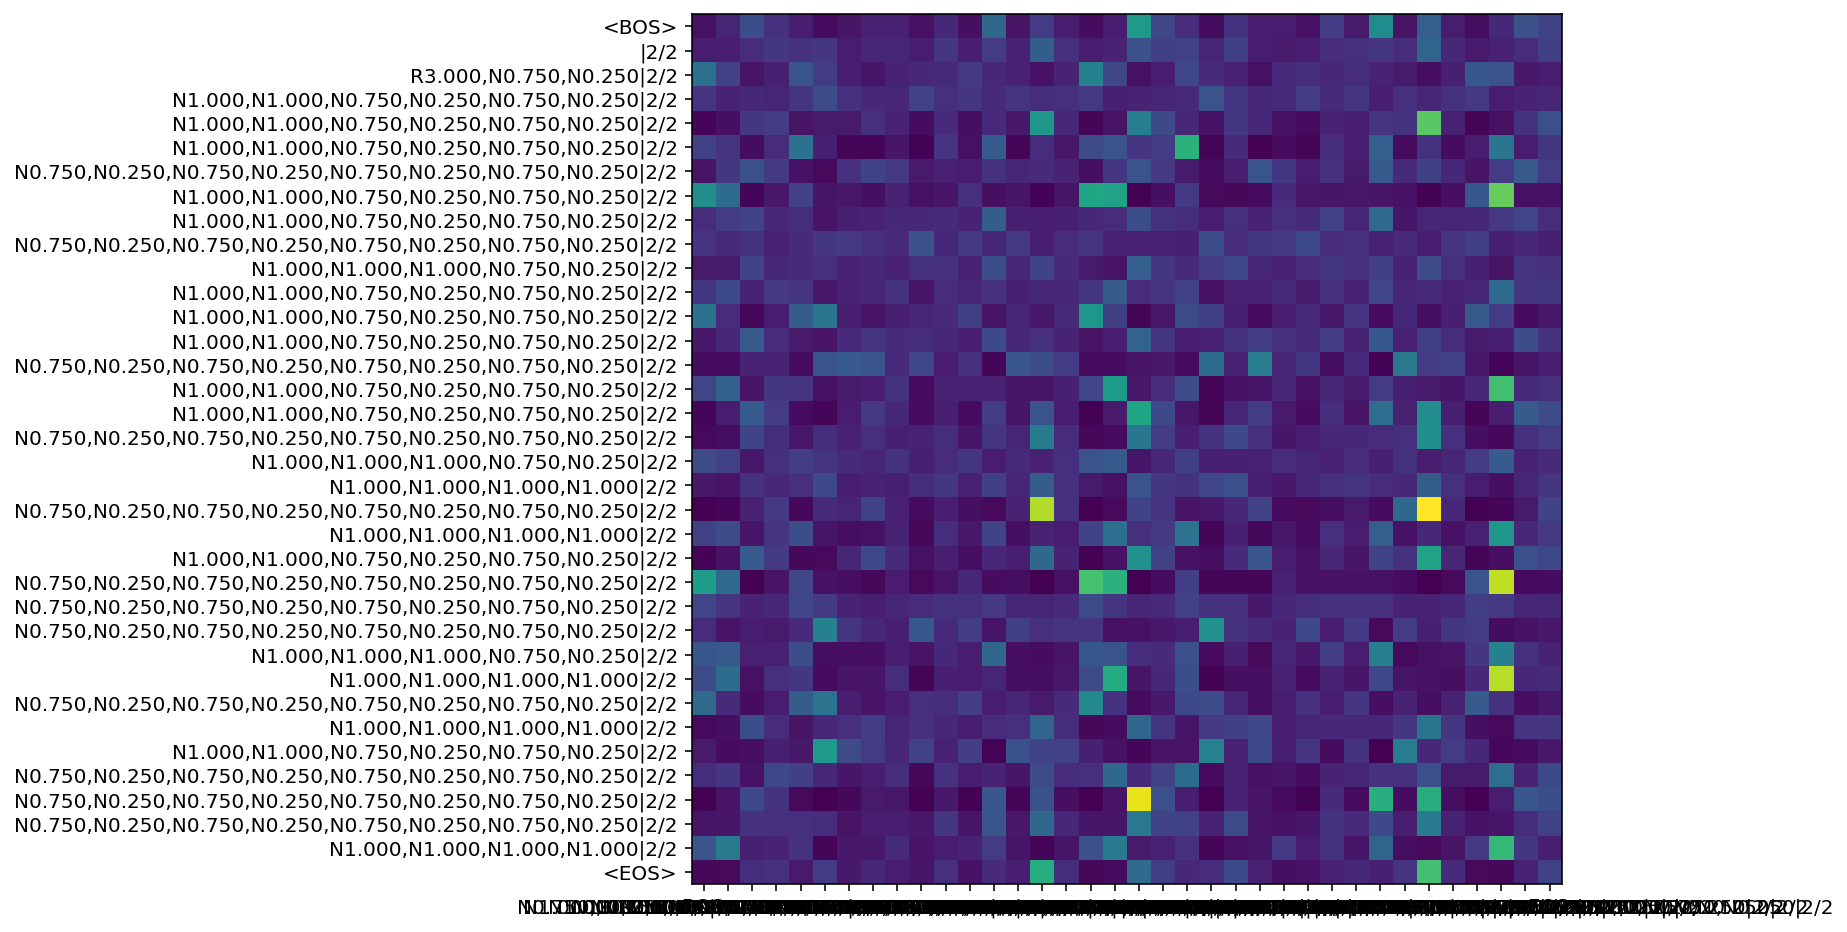

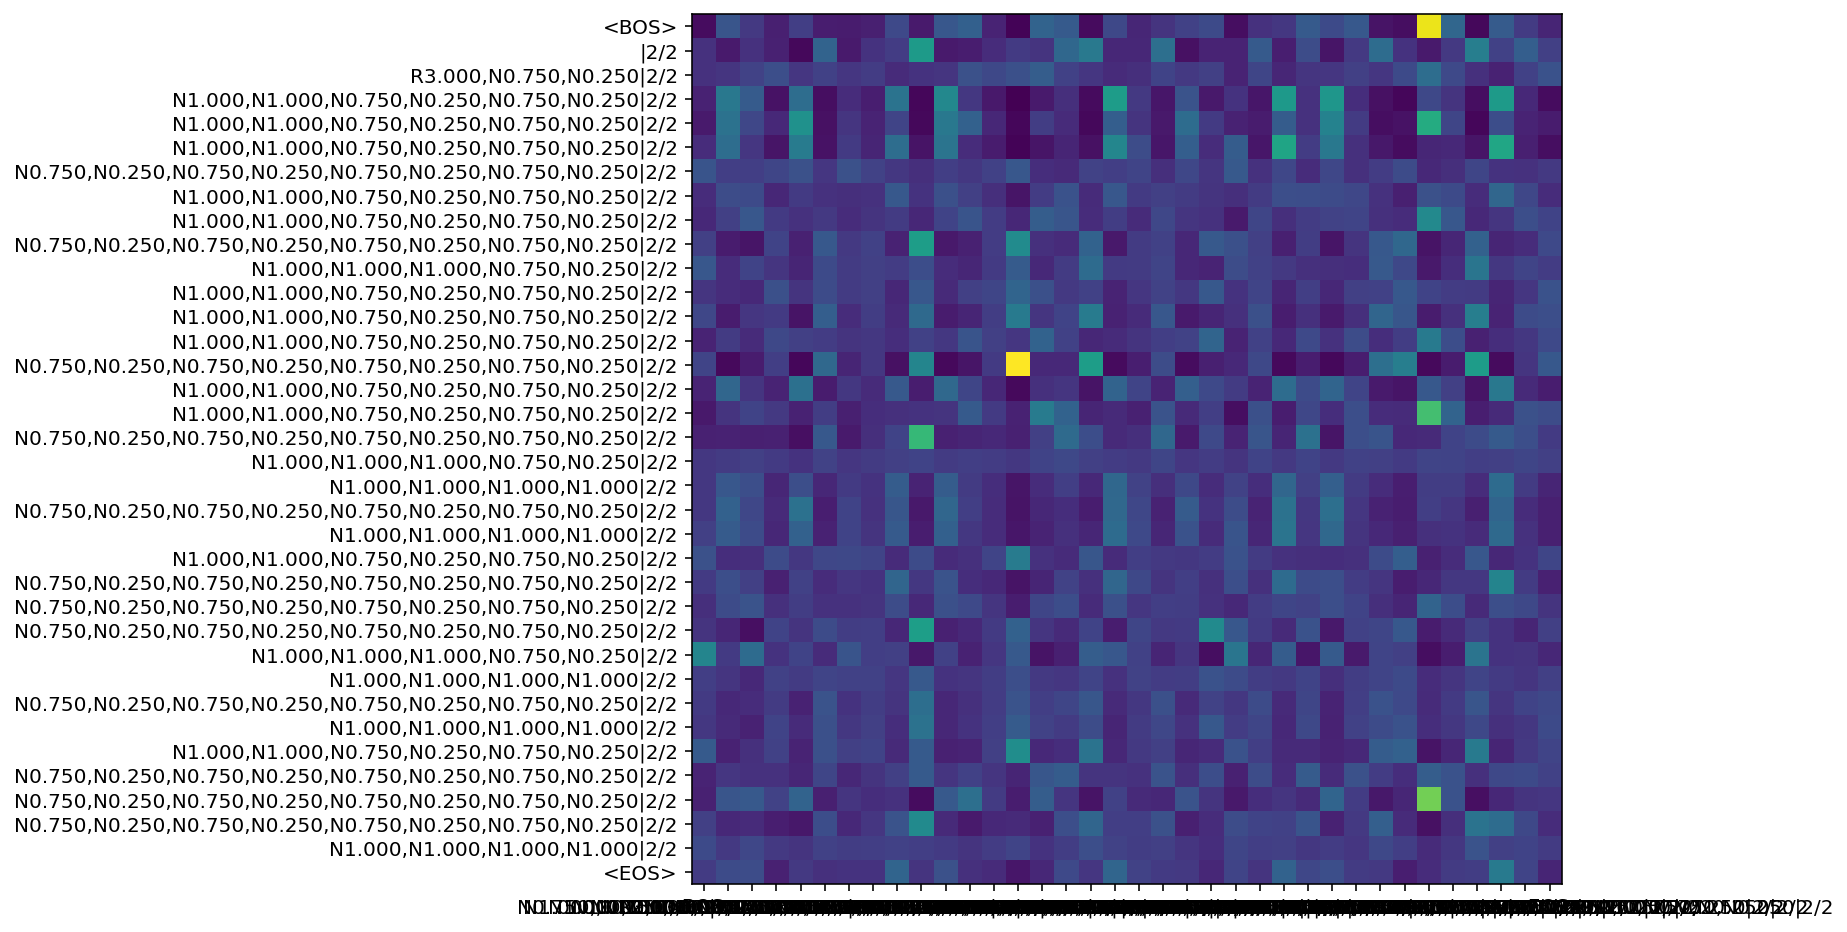

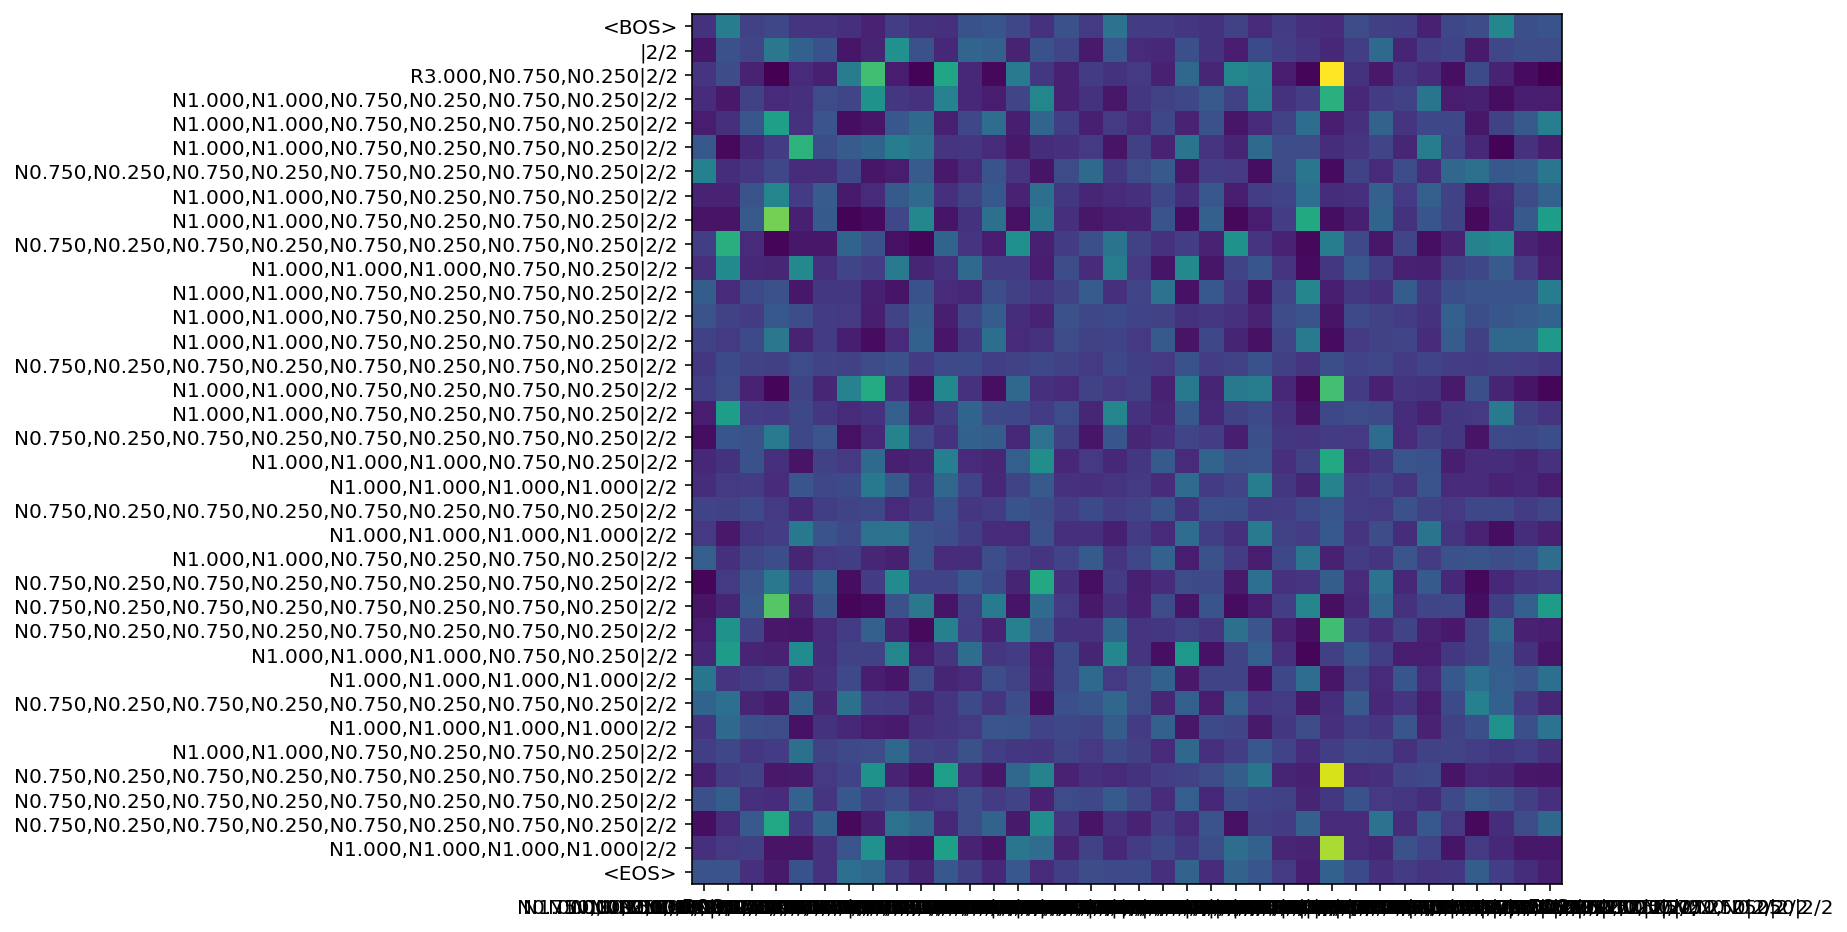

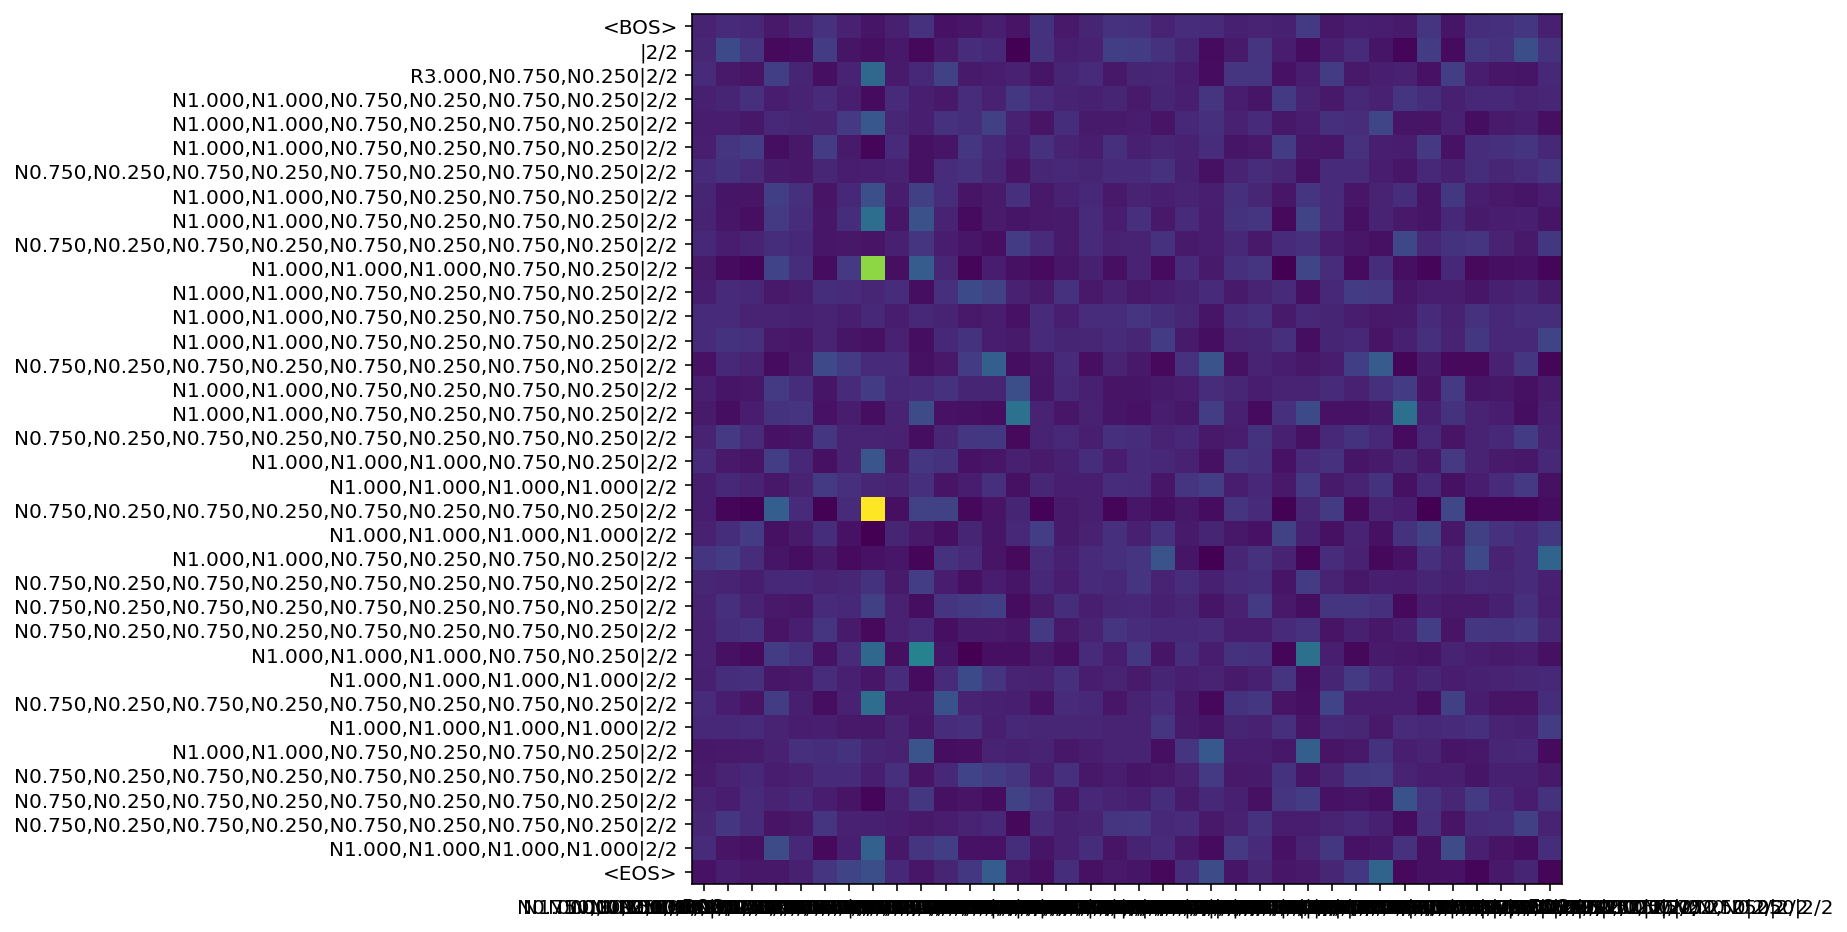

In [ ]:
trial_VQRhythmModel.eval()

data_package = next(zero_mask_rhythm_iter)
print(data_package['id'])
this_len = data_package['sentence_idx'].shape[1]
input_len = torch.LongTensor([[this_len]]).to(device)
output_package = trial_VQRhythmModel(data_package['sentence_idx'],
                                        data_package['sentence_meter'],
                                        input_len,var_factor=0.0)
output_meter_logit = output_package['output_meter']
output_grouping_logit = output_package['output_grouping']

output_meter_pred = torch.argmax(output_meter_logit,dim=2)
output_grouping_pred = torch.argmax(output_grouping_logit,dim=2)

output_meter_logit = output_meter_logit.transpose(1, 2)
output_grouping_logit = output_grouping_logit.transpose(1, 2)

loss_meter = loss_function(output_meter_logit,data_package['sentence_meter'])
loss_grouping = loss_function(output_grouping_logit,data_package['sentence_grouping'])
loss_classification = loss_meter+loss_grouping

print(loss_classification)
print('VQ embedding indexes:',output_package['encoding_indices'])
print(data_package['sentence_meter'])
print(output_meter_pred)
print(data_package['sentence_grouping'])
print(output_grouping_pred)

enc_self_attn = output_package['attentions']
ref = tokens2sentence(data_package['target'].tolist(),rhythm_dataset.int2word)

# for lay in range(config.n_layers):
#     for h in range(config.num_heads):
#         attn_ave += enc_self_attn[lay][h]
# attn_ave = attn_ave/(config.n_layers*config.num_heads)
attn_ave = enc_self_attn[2][4]
plot_attention(ref[0], attn_ave)
attn_ave = enc_self_attn[3][4]
plot_attention(ref[0], attn_ave)
attn_ave = enc_self_attn[4][4]
plot_attention(ref[0], attn_ave)
attn_ave = enc_self_attn[5][4]
plot_attention(ref[0], attn_ave)

### show learning curves

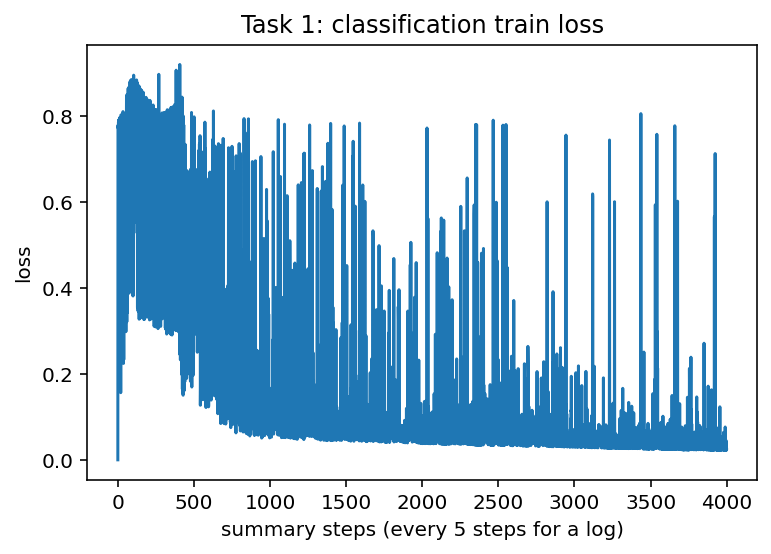

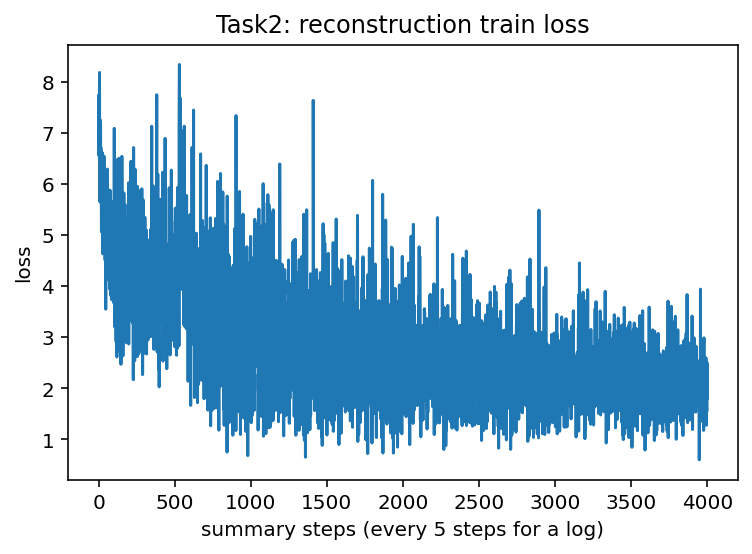

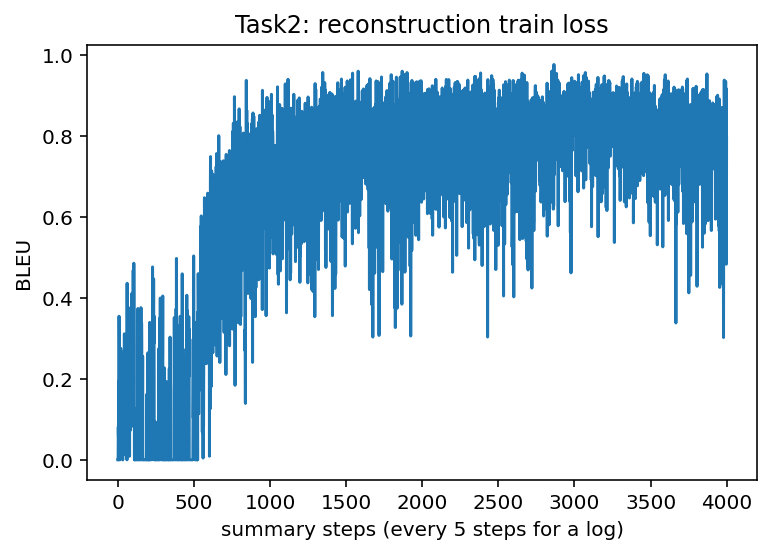

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses_class)
plt.xlabel('summary steps (every 5 steps for a log)')
plt.ylabel('loss')
plt.title('Task 1: classification train loss')
plt.show()

plt.figure()
plt.plot(losses_pred)
plt.xlabel('summary steps (every 5 steps for a log)')
plt.ylabel('loss')
plt.title('Task2: reconstruction train loss')
plt.show()

plt.figure()
plt.plot(bleus_train)
plt.xlabel('summary steps (every 5 steps for a log)')
plt.ylabel('BLEU')
plt.title('Task2: reconstruction train loss')
plt.show()

### Show tSNE

In [ ]:
rhythm_loader4tsne = data.DataLoader(zero_mask_rhythm_dataset, batch_size=config.batch_size, shuffle=False)

vq_meter_vocab = {}
vq_emb_id_vocab = {}
vq_meter_freq_vocab  = {}
vocab_bias = 0
for input_package in rhythm_loader4tsne:
    this_len = input_package['sentence_idx'].shape[1]
    input_len = torch.LongTensor([[this_len]]).to(device)
    output_package = trial_VQRhythmModel(input_package['sentence_idx'],
                                         input_package['sentence_meter'],
                                         input_len,var_factor=0.001)
    vq_indexes = output_package['encoding_indices'][0]
    meter_indexes = input_package['sentence_meter'][0]
    vq_vecs = output_package['zq'][0]
    for time,vq_id in enumerate(vq_indexes):
        meter = meter_indexes[time]
        this_vec = vq_vecs[time]#[time,0:sum(config.splitted_dim_list[0:2])]
        vq_id = vq_id.item()
        if vq_id not in vq_emb_id_vocab:
            vq_emb_id_vocab.update({vq_id:this_vec.cpu().detach().numpy()})
            vocab_bias += 1
            vq_meter_vocab.update({vq_id:meter.item()})
            vq_meter_freq_vocab.update({vq_id:0})
        else:
            vq_meter_freq_vocab[vq_id] += 1
print(vq_meter_vocab)

{2315: 0, 899: 4, 2102: 4, 1948: 4, 2310: 4, 414: 0, 1831: 1, 741: 1, 2332: 1, 1000: 1, 478: 1, 2230: 1, 2017: 1, 2321: 1, 1947: 1, 148: 7, 2257: 7, 1800: 7, 2312: 7, 376: 7, 1549: 7, 1206: 3, 1693: 3, 1914: 3, 1476: 3, 1768: 3, 1559: 3, 2340: 3, 582: 3, 1114: 2, 961: 2, 2262: 2, 2322: 2, 2331: 2, 831: 2, 457: 2, 2013: 1, 2345: 1, 1823: 1, 1335: 1, 1788: 1, 1350: 1, 318: 4, 218: 4, 1673: 7, 1552: 7, 1933: 7, 1657: 7, 1701: 7, 2341: 7, 1539: 7, 2023: 7, 1185: 7, 2211: 7, 2343: 1, 2307: 1, 1551: 1, 1085: 1, 2007: 1, 2227: 1, 103: 1, 297: 1, 1733: 1, 1647: 1, 2317: 3, 601: 4, 2316: 4, 993: 4, 25: 1, 737: 1, 859: 1, 262: 1, 2118: 1, 1570: 2, 1854: 4, 1576: 4, 752: 4, 2030: 4, 2327: 4, 2325: 0, 2024: 4, 1324: 1, 1144: 1, 1861: 1, 1351: 1, 116: 1, 749: 4, 609: 1, 1898: 0, 2077: 3, 319: 3, 2015: 4, 1437: 1, 1416: 0, 724: 3, 728: 3, 1080: 3, 1249: 3, 1936: 7, 230: 7, 2336: 4, 2318: 4, 2308: 4, 2294: 4, 814: 4, 1098: 4, 2337: 11, 2329: 11, 1675: 5, 1751: 4, 1646: 1, 2339: 2, 2241: 2, 2309: 2, 2

(178, 64)
(178,)


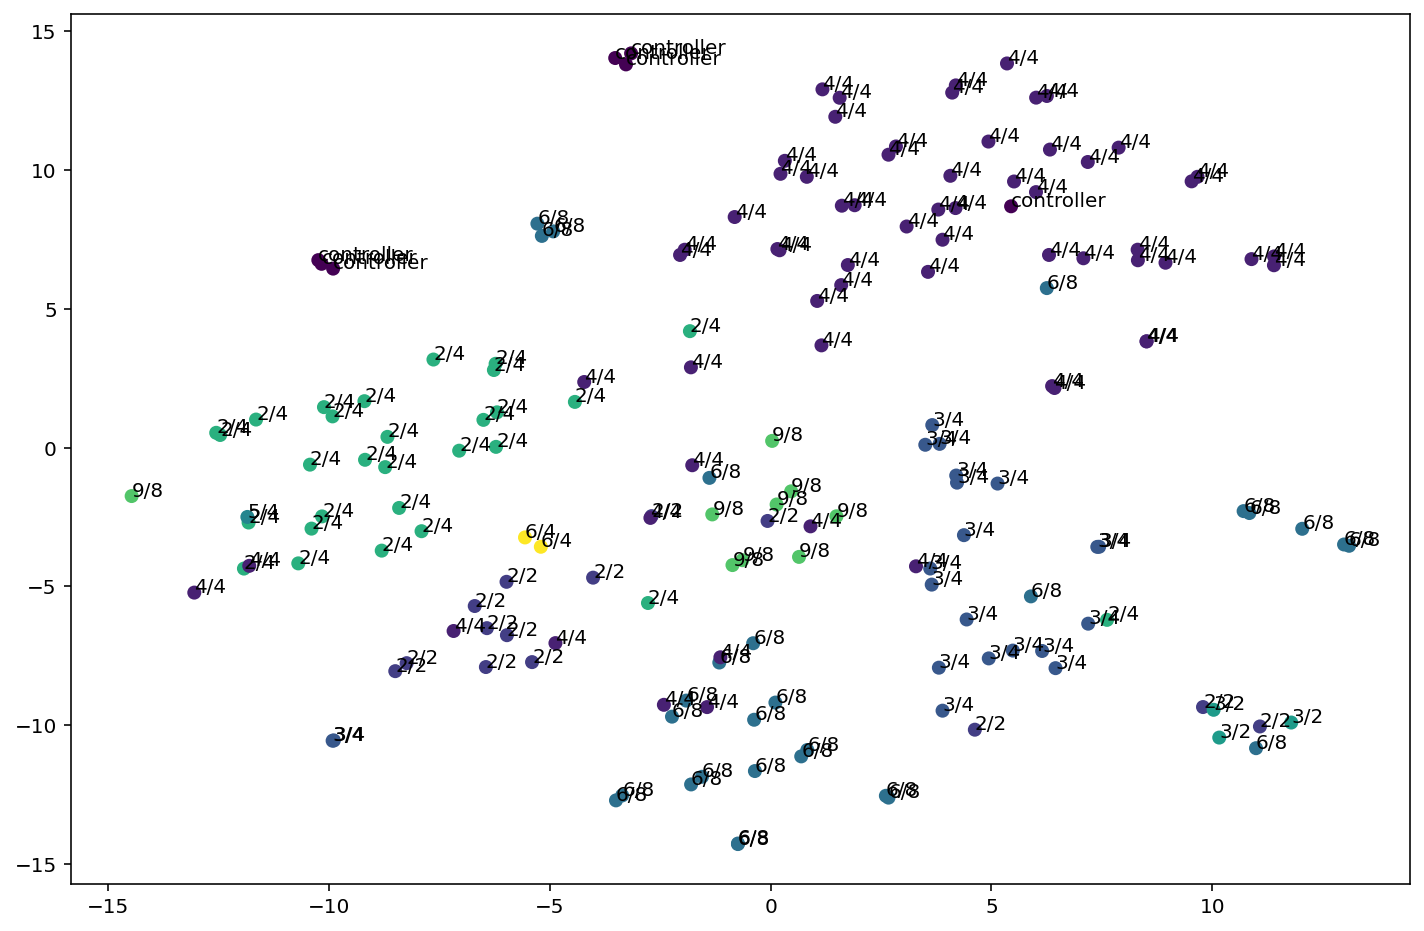

In [ ]:
vq_embedding_array = np.array(list(vq_emb_id_vocab.values()))
print(vq_embedding_array.shape)
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(vq_embedding_array)
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
class_list = list(vq_meter_vocab.values())
class_array = np.array(class_list)
print(class_array.shape)
ax.scatter(X_tsne[:,0],X_tsne[:,1],c=class_list)
for i in range(len(X_tsne)):
    x=X_tsne[i][0]
    y=X_tsne[i][1]
    string_tmp = rhythm_dataset.class_contents_int2class[class_list[i]]
    ax.text(x , y , string_tmp ,size = 10)
        # if i in rhythm_dataset.int2word:
        #     string_tmp = rhythm_dataset.int2word[i]
        #     meter_index = string_tmp.find('|')
        #     if meter_index>0:
        #         if i%10==0:
        #             suffix = string_tmp[meter_index+1:]
        #             ax.text(x , y , suffix ,size = 10)
        #     elif meter_index==0:

plt.show()

### save model

In [ ]:
torch.save(trial_VQRhythmModel, f'{config.store_model_path}/model_20200713_1.model') #Please change the path for your environment
print ('successfully save model!')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VQRhythmModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


PicklingError: ignored

### load model

In [ ]:
loaded_VQRhythmModel = VQRhythmModel(config,rhythm_dataset.vocab_size,commitment_cost=0.25,decay=0.99,epsilon=1e-5, use_vq = True).to(device)
loaded_VQRhythmModel = torch.load(f'{config.store_model_path}/model_20200712_10.model') #Please change the path for your environment
loaded_VQRhythmModel.eval()

VQRhythmModel(
  (emb_layer): EmbeddingLayer(
    (seq_embedding): Embedding(471, 64, padding_idx=0)
    (token_type_embedding): Embedding(13, 64, padding_idx=0)
    (pos_embedding): PositionalEncoding(
      (position_encoding): Embedding(800, 64)
    )
  )
  (vq_encoder): VQEncoder(
    (encoder): TransformerEncoder(
      (encoder_layers): ModuleList(
        (0): EncoderLayer(
          (attention): MultiHeadAttention(
            (linear_k): Linear(in_features=64, out_features=64, bias=True)
            (linear_v): Linear(in_features=64, out_features=64, bias=True)
            (linear_q): Linear(in_features=64, out_features=64, bias=True)
            (dot_product_attention): ScaledDotProductAttention(
              (dropout): Dropout(p=0.5, inplace=False)
              (softmax): Softmax(dim=2)
            )
            (linear_final): Linear(in_features=64, out_features=64, bias=True)
            (dropout): Dropout(p=0.5, inplace=False)
            (layer_norm): LayerNorm((64,), 

tensor([22])
tensor(3.2678, grad_fn=<AddBackward0>)
VQ embedding indexes: tensor([[ 709, 1847, 2295, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 1751, 2025,
         2025, 2025, 2025, 2025, 2025, 2025, 2316]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])
tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])
tensor([[4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])


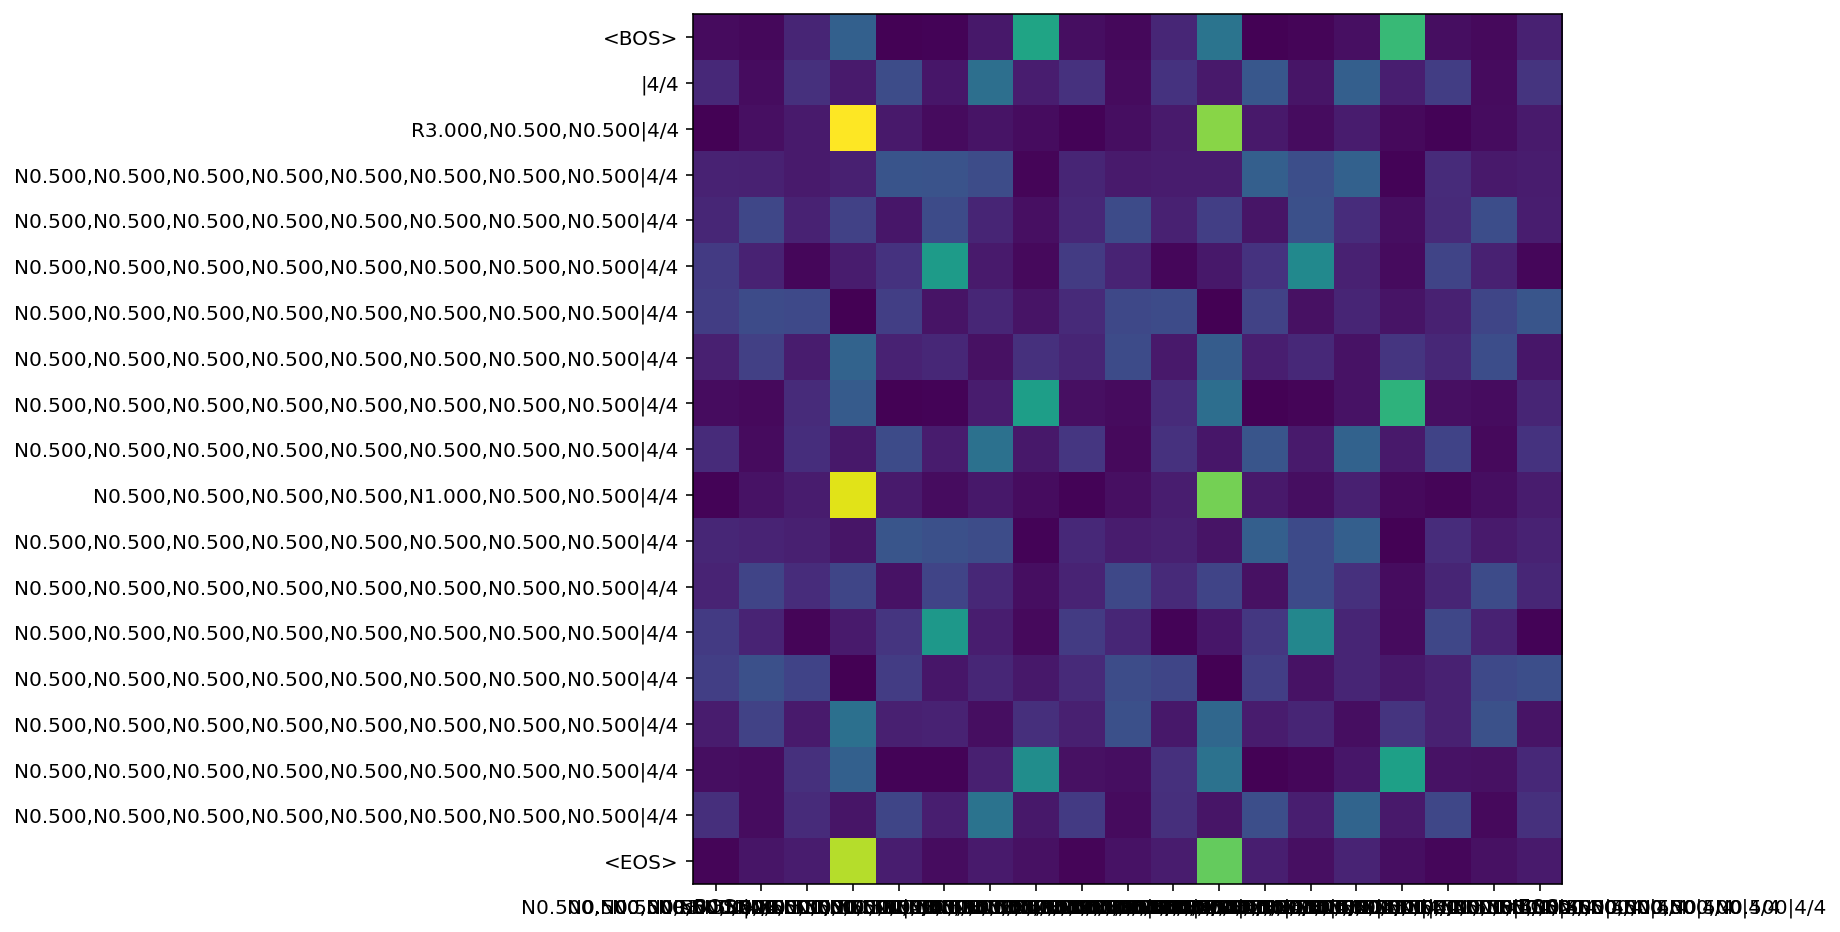

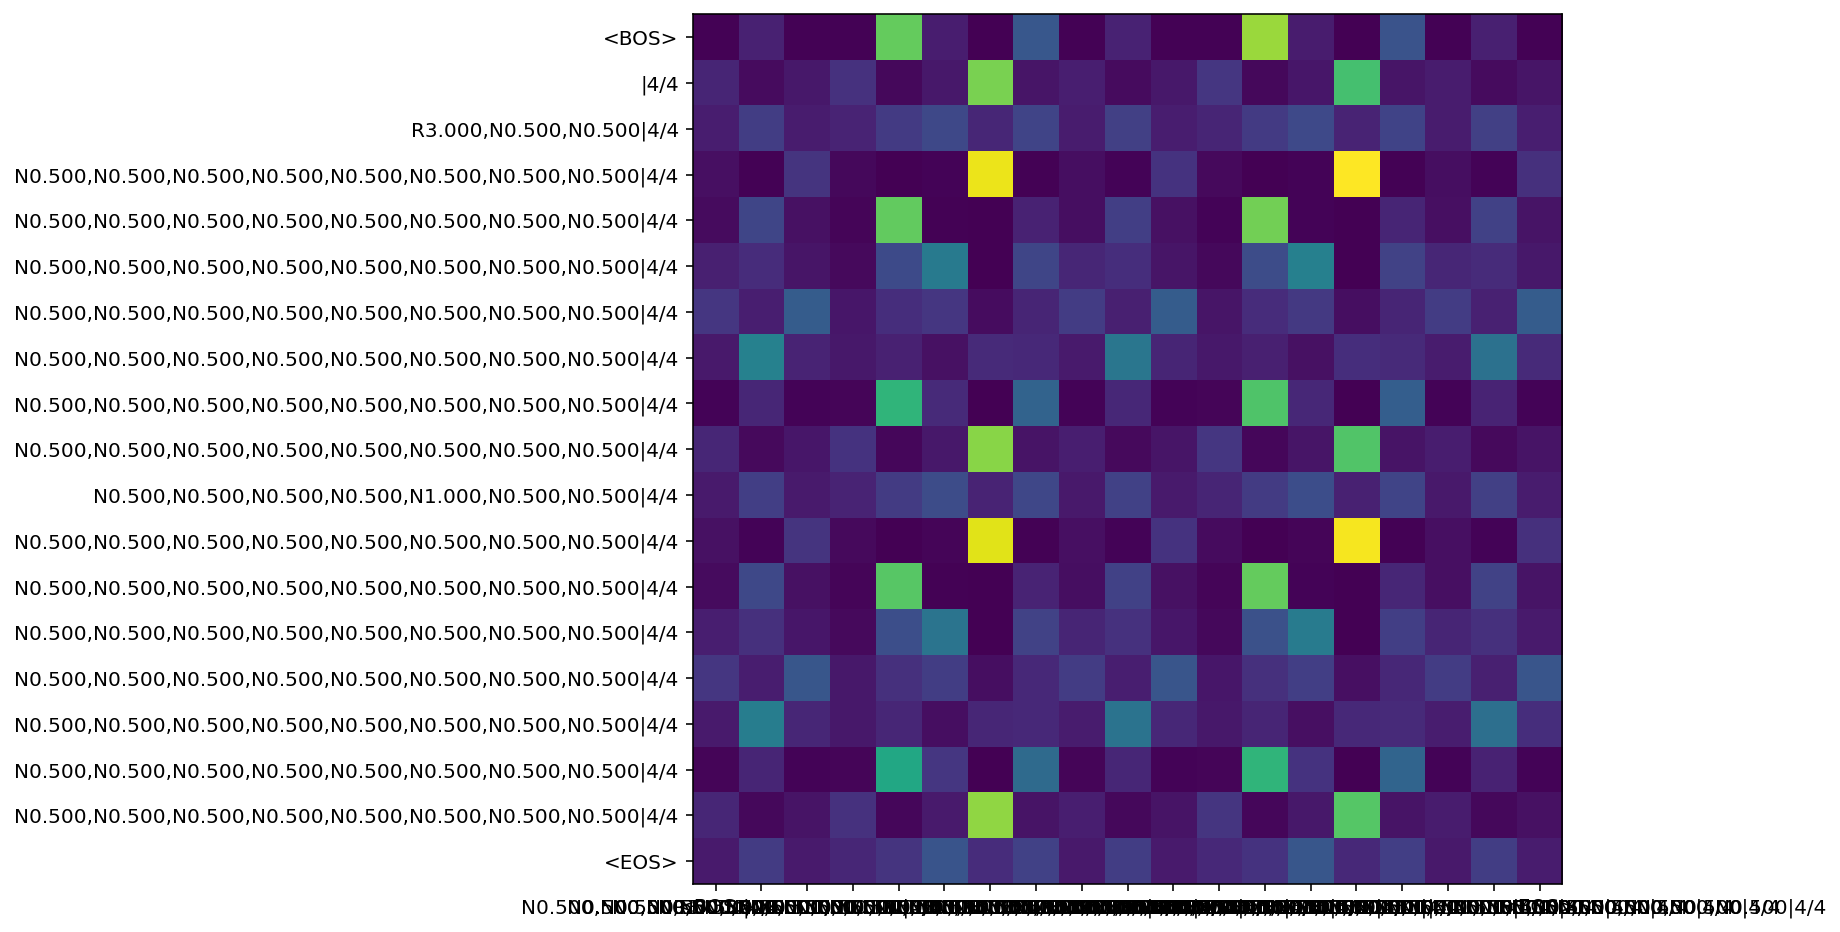

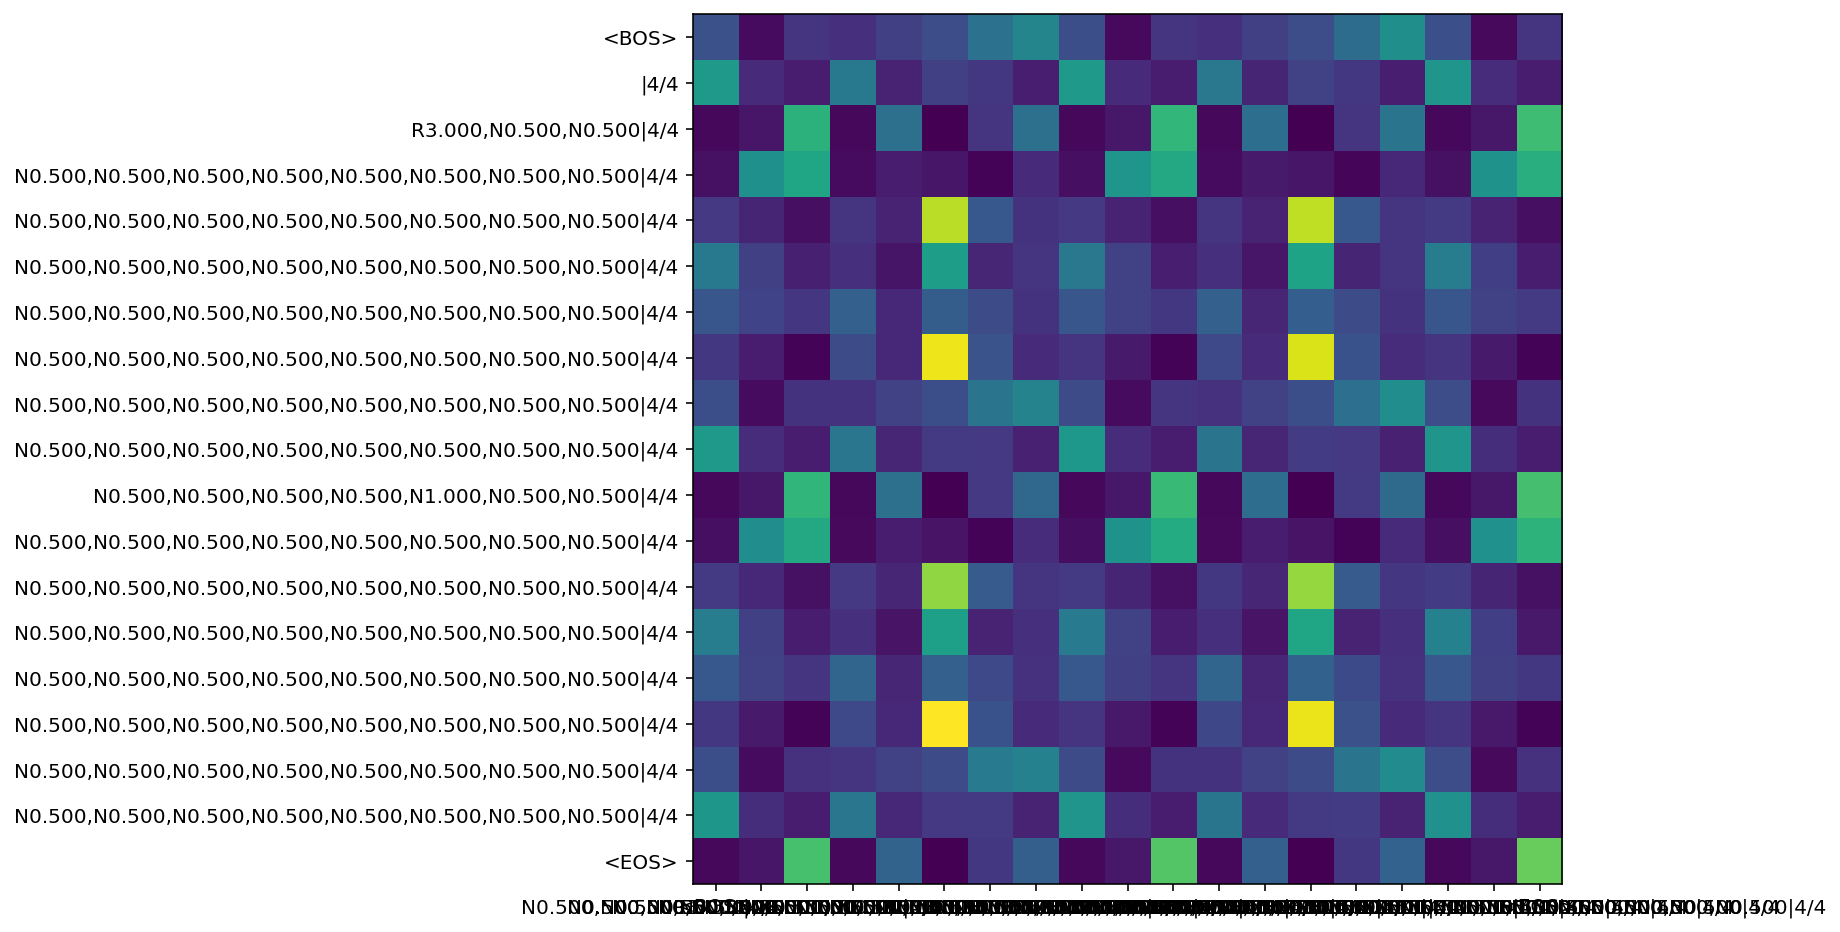

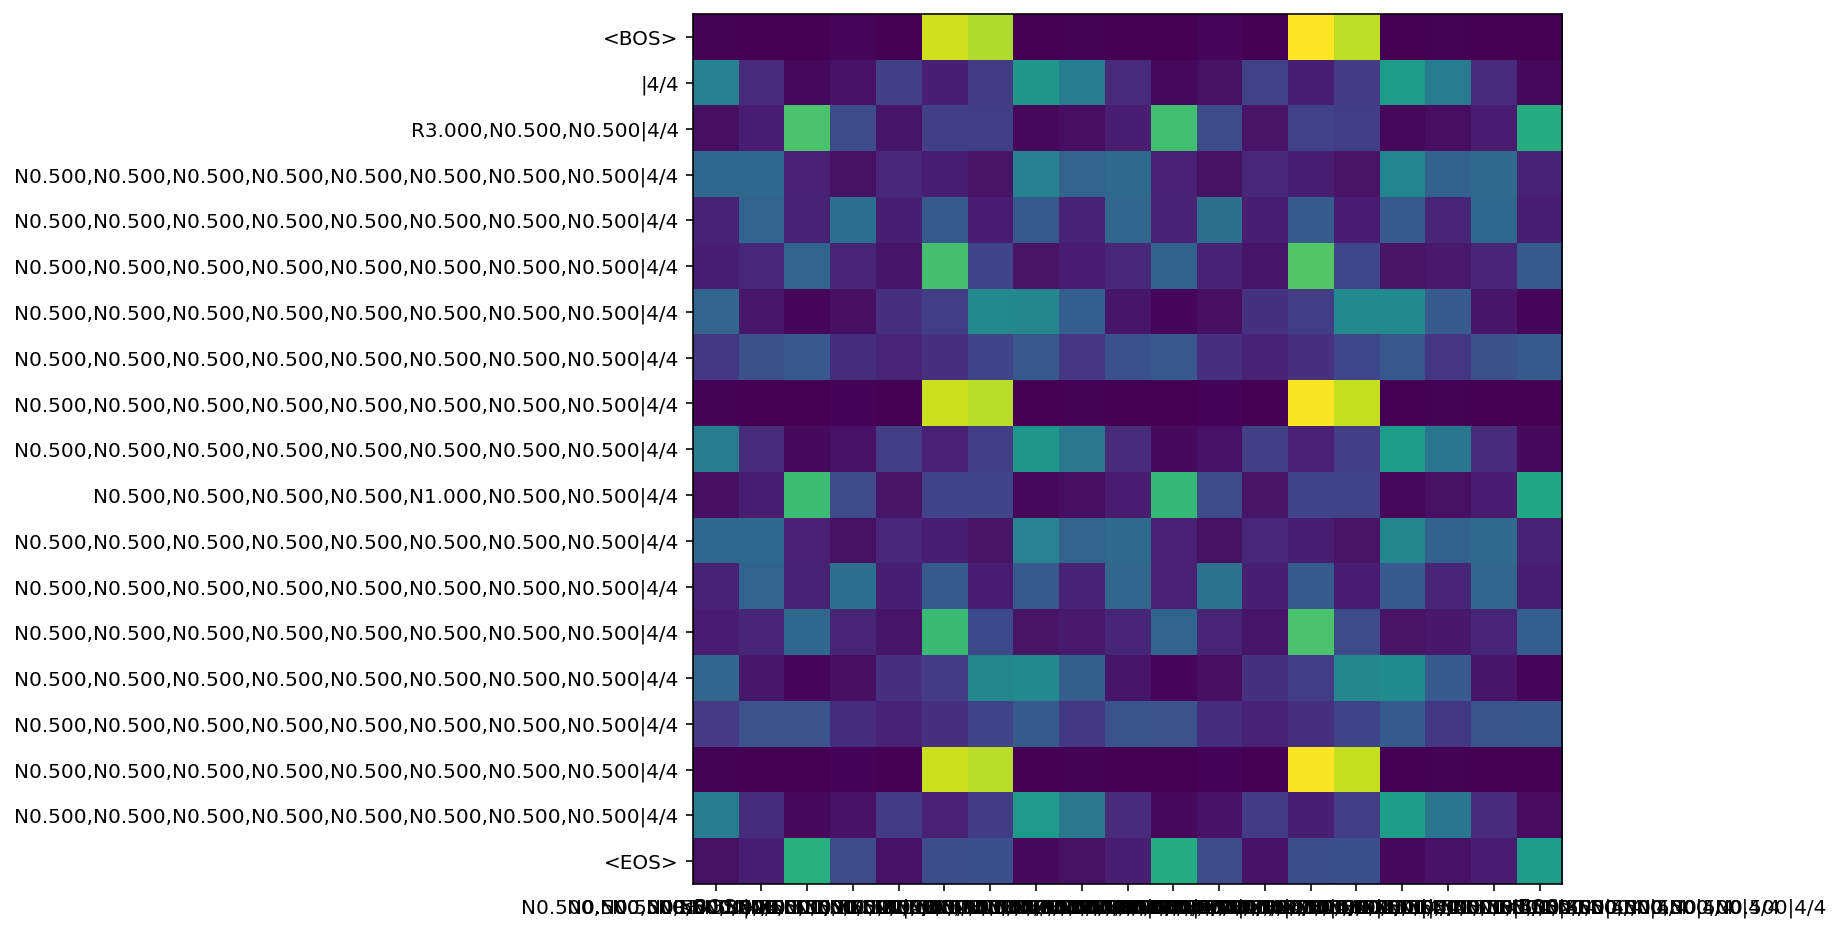

In [ ]:
data_package = next(zero_mask_rhythm_iter)
print(data_package['id'])
this_len = data_package['sentence_idx'].shape[1]
input_len = torch.LongTensor([[this_len]]).to(device)
output_package = loaded_VQRhythmModel(data_package['sentence_idx'],
                                        data_package['sentence_meter'],
                                        input_len,var_factor=0.0)
output_meter_logit = output_package['output_meter']
output_grouping_logit = output_package['output_grouping']

output_meter_pred = torch.argmax(output_meter_logit,dim=2)
output_grouping_pred = torch.argmax(output_grouping_logit,dim=2)

output_meter_logit = output_meter_logit.transpose(1, 2)
output_grouping_logit = output_grouping_logit.transpose(1, 2)

loss_meter = loss_function(output_meter_logit,data_package['sentence_meter'])
loss_grouping = loss_function(output_grouping_logit,data_package['sentence_grouping'])
loss_classification = loss_meter+loss_grouping

print(loss_classification)
print('VQ embedding indexes:',output_package['encoding_indices'])
print(data_package['sentence_meter'])
print(output_meter_pred)
print(data_package['sentence_grouping'])
print(output_grouping_pred)

enc_self_attn = output_package['attentions']
ref = tokens2sentence(data_package['target'].tolist(),rhythm_dataset.int2word)

# for lay in range(config.n_layers):
#     for h in range(config.num_heads):
#         attn_ave += enc_self_attn[lay][h]
# attn_ave = attn_ave/(config.n_layers*config.num_heads)
attn_ave = enc_self_attn[2][2]
plot_attention(ref[0], attn_ave)
attn_ave = enc_self_attn[3][2]
plot_attention(ref[0], attn_ave)
attn_ave = enc_self_attn[4][2]
plot_attention(ref[0], attn_ave)
attn_ave = enc_self_attn[5][2]
plot_attention(ref[0], attn_ave)

### track word mappings

In [ ]:
rhythm_loader4tsne = data.DataLoader(zero_mask_rhythm_dataset, batch_size=config.batch_size, shuffle=False)

vq_meter_vocab = {}
vq_word_vocab = {}
vq_emb_id_vocab = {}
vq_meter_freq_vocab  = {}
vocab_bias = 0
for input_package in rhythm_loader4tsne:
    this_len = input_package['sentence_idx'].shape[1]
    input_len = torch.LongTensor([[this_len]]).to(device)
    output_package = loaded_VQRhythmModel.MLM_predict(input_package['sentence_idx'],
                                         input_package['sentence_meter'],
                                         input_len)
    
    output_logit_pred = output_package['output_pred']
    output_pred = torch.argmax(output_logit_pred,dim=2)
    preds_word = tokens2sentence(output_pred, rhythm_loader4tsne.dataset.int2word)
    targets_word = tokens2sentence(input_package['target'], rhythm_loader4tsne.dataset.int2word)

    vq_indexes = output_package['encoding_indices'][0]
    meter_indexes = input_package['sentence_meter'][0]
    vq_vecs = output_package['zq'][0]
    for time,vq_id in enumerate(vq_indexes):
        meter = meter_indexes[time]
        this_vec = vq_vecs[time]
        this_word_str = targets_word[0][time]
        vq_id = vq_id.item()
        if vq_id not in vq_emb_id_vocab:
            vq_emb_id_vocab.update({vq_id:this_vec.cpu().detach().numpy()})
            vocab_bias += 1
            vq_meter_vocab.update({vq_id:meter.item()})
            vq_meter_freq_vocab.update({vq_id:0})
            vq_word_vocab.update({vq_id:[this_word_str]})#
        else:
            vq_meter_freq_vocab[vq_id] += 1
            if this_word_str not in vq_word_vocab[vq_id]:
                vq_word_vocab[vq_id].append(this_word_str)

In [ ]:
for vq_id in vq_meter_vocab:
    print('----- vq id = ',vq_id,' ----')
    print(vq_meter_vocab[vq_id])
    print(vq_word_vocab[vq_id])

----- vq id =  709  ----
0
['<BOS>']
----- vq id =  1776  ----
4
['|6/8', 'R2.000,N0.500,N0.500|6/8', 'R1.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N1.500|6/8', 'N1.500,N1.000,N0.500|6/8', 'N0.500,N0.500,N0.500,N1.000,N0.500|6/8', 'N0.750,N0.250,N0.500,N1.000,N0.500|6/8', 'N3.000|6/8', 'H1.500,R1.000,N0.500|6/8']
----- vq id =  90  ----
4
['R2.500,N0.500|6/8']
----- vq id =  2236  ----
4
['N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N1.000|6/8', 'N0.500,N0.500,N0.500,N1.500|6/8', 'N1.500,N0.500,N0.500,N0.500|6/8', 'N1.000,N1.500,R0.500|6/8', 'N1.500,N0.500,N1.000|6/8', 'N0.500,N1.000,N0.500,N1.000|6/8', 'N1.500,N0.500,N0.250,N0.250,N0.250,N0.250|6/8', 'N1.500,N1.000,N0.500|6/8', 'N0.750,N0.250,N0.500,N0.750,N0.250,N0.500|6/8', 'N1.000,N0.500,N1.500|6/8', 'H1.000,R0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N1.000,N1.000,N0.500|6/8', 'N3.000,N1.000|4/4', 'N1.000,N1.000,N1.000,N1.000|4/4']
----- vq id =  599  ----
4
['N1.500,N1.500|6/8', 'N0.250,N

In [ ]:
tmp_vq_id = 2311
tmp_vq_id2 = 2299
tmp_vq_id3 = 1649
word_mapping_id = 0

vq_for_test = torch.FloatTensor(vq_emb_id_vocab[tmp_vq_id][config.splitted_dim_list[0]+config.splitted_dim_list[1]:])

this_meter_str = vq_word_vocab[tmp_vq_id][word_mapping_id]
this_word_idx = rhythm_dataset.word2int[this_meter_str]
this_meter_idx = rhythm_dataset.word_idx2meter_idx[this_word_idx]

meter_cond = torch.zeros(config.classifier_out_len_list[0])
meter_cond.scatter_(0,torch.tensor(this_meter_idx),1)

this_pred_input = torch.cat((meter_cond,vq_for_test),dim=0).to(device)
this_pred_output_logit = loaded_VQRhythmModel.classifier_pred(this_pred_input,torch.tensor(this_meter_idx))
this_pred_output = torch.argmax(this_pred_output_logit,dim=0)

print('original word: ',this_meter_str)
print('pred word str: ',rhythm_dataset.int2word[this_pred_output.item()])


original word:  N0.500,N1.000,N0.500,N1.000,N1.000|4/4
pred word str:  N1.500,N0.500,N1.000,N1.000|4/4


In [ ]:

context_dict = {'vq_id':tmp_vq_id}
context_dict2 = {'vq_id':tmp_vq_id2}
context_dict3 = {'vq_id':tmp_vq_id3}
rhythm_loader4tsne = data.DataLoader(zero_mask_rhythm_dataset, batch_size=config.batch_size, shuffle=False)

for input_package in rhythm_loader4tsne:
    this_piece_id = input_package['id'].item()
    this_len = input_package['sentence_idx'].shape[1]
    input_len = torch.LongTensor([[this_len]]).to(device)
    output_package = loaded_VQRhythmModel.MLM_predict(input_package['sentence_idx'],
                                        input_package['sentence_meter'],
                                        input_len)
    
    output_logit_pred = output_package['output_pred']
    output_pred = torch.argmax(output_logit_pred,dim=2)
    preds_word = tokens2sentence(output_pred, rhythm_loader4tsne.dataset.int2word)
    targets_word = tokens2sentence(input_package['target'], rhythm_loader4tsne.dataset.int2word)

    vq_indexes = output_package['encoding_indices'][0]
    meter_indexes = input_package['sentence_meter'][0]
    vq_vecs = output_package['zq'][0]
    for time,vq_id in enumerate(vq_indexes):
        meter = meter_indexes[time]
        this_vec = vq_vecs[time]
        this_word_str = targets_word[0][time]
        vq_id = vq_id.item()
        if int(vq_id) == int(tmp_vq_id):
            if this_piece_id not in context_dict:
                context_dict.update({this_piece_id:[time]})
            else:
                context_dict[this_piece_id].append(time)
        if int(vq_id) == int(tmp_vq_id2):
            if this_piece_id not in context_dict2:
                context_dict2.update({this_piece_id:[time]})
            else:
                context_dict2[this_piece_id].append(time)
        if int(vq_id) == int(tmp_vq_id3):
            if this_piece_id not in context_dict3:
                context_dict3.update({this_piece_id:[time]})
            else:
                context_dict3[this_piece_id].append(time)

In [ ]:
print(context_dict)
print(context_dict2)
print(context_dict3)

{'vq_id': 2311, 5: [4, 5, 12, 44, 46], 14: [11, 35], 42: [3], 54: [7], 57: [3, 11], 312: [6, 27, 48], 368: [6, 14, 22], 370: [5, 6, 13, 14, 21, 22, 35, 71, 74, 98], 374: [13, 17], 379: [62, 70], 402: [49], 404: [5, 7, 8, 13], 407: [21], 415: [7, 11, 15, 19, 23, 27, 31, 35, 39], 419: [11, 13, 14, 15], 420: [6], 438: [6, 14, 16], 439: [4, 12], 443: [7, 15], 446: [13, 15], 455: [10, 22, 30], 466: [19], 472: [41, 67, 71], 479: [26, 50], 484: [3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29], 489: [21], 493: [20], 495: [3, 5, 7, 11, 13, 15, 19, 21, 23, 27, 31], 500: [7, 11, 15], 506: [19, 21], 510: [19], 535: [9, 11, 17], 536: [21], 543: [21], 548: [9, 17, 19, 27, 31, 35, 36, 43, 44], 556: [19, 21], 571: [17], 579: [4, 6], 582: [7, 11, 19, 27], 584: [5, 7, 13, 15], 586: [21], 591: [9], 593: [5, 7, 9, 11, 13, 15, 17, 19, 21, 27, 29], 594: [7, 11], 595: [18, 26], 597: [8, 12, 16], 598: [3, 20], 600: [19], 606: [19], 607: [5, 7, 13, 15, 21, 23, 27], 610: [42, 44], 618: [10, 22], 619: [19, 20, 2

In [ ]:
#print('this vq id for test is: ',context_dict['vq_id'])
piece_id_for_test = 5
print('piece number',piece_id_for_test)
for time,word_str in enumerate(zero_mask_rhythm_dataset.data[piece_id_for_test]):
    if piece_id_for_test in context_dict and time in context_dict[piece_id_for_test]:
        print(f'\033[1;32;43m time {str(time)}: {word_str} ; bingo vq id {str(tmp_vq_id)}! \033[0m')
    elif piece_id_for_test in context_dict2 and time in context_dict2[piece_id_for_test]:
        print(f'\033[1;32;43m time {str(time)}: {word_str} ; bingo vq id {str(tmp_vq_id2)}! \033[0m')
    elif piece_id_for_test in context_dict3 and time in context_dict3[piece_id_for_test]:
        print(f'\033[1;32;43m time {str(time)}: {word_str} ; bingo vq id {str(tmp_vq_id3)}! \033[0m')
    else:
        print(f'time {str(time)}: {word_str}')

piece number 5
time 0: <BOS>
time 1: |4/4
time 2: R3.000,N1.000|4/4
time 3: N1.000,N1.000,N1.000,N1.000|4/4
 time 4: N0.500,N1.000,N0.500,N1.000,N1.000|4/4 ; bingo vq id 2311! 
 time 5: N0.500,N1.000,N0.500,N1.000,N1.000|4/4 ; bingo vq id 2311! 
 time 6: N0.500,N1.000,N0.500,N1.000,N1.000|4/4 ; bingo vq id 1649! 
time 7: N1.000,N1.000,N1.000,N1.000|4/4
 time 8: N0.500,N1.000,N0.500,N1.000,N1.000|4/4 ; bingo vq id 1649! 
time 9: N1.000,N1.000,N1.000,N1.000|4/4
time 10: N3.000,N1.000|4/4
time 11: N1.000,N1.000,N1.000,N1.000|4/4
 time 12: N0.500,N1.000,N0.500,N1.000,N1.000|4/4 ; bingo vq id 2311! 
 time 13: N0.500,N1.000,N0.500,N1.000,N1.000|4/4 ; bingo vq id 1649! 
 time 14: N0.500,N1.000,N0.500,N1.000,N1.000|4/4 ; bingo vq id 1649! 
time 15: N1.000,N1.000,N1.000,N1.000|4/4
 time 16: N0.500,N1.000,N0.500,N1.000,N1.000|4/4 ; bingo vq id 1649! 
time 17: N1.000,N1.000,N1.000,N1.000|4/4
time 18: N3.000,N1.000|4/4
time 19: N1.000,N1.000,N1.000,N1.000|4/4
 time 20: N0.500,N1.000,N0.500,N1.000,

(145, 64)
[['<BOS>'], ['|6/8', 'R2.000,N0.500,N0.500|6/8', 'R1.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N1.500|6/8', 'N1.500,N1.000,N0.500|6/8', 'N0.500,N0.500,N0.500,N1.000,N0.500|6/8', 'N0.750,N0.250,N0.500,N1.000,N0.500|6/8', 'N3.000|6/8', 'H1.500,R1.000,N0.500|6/8'], ['R2.500,N0.500|6/8'], ['N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N1.000|6/8', 'N0.500,N0.500,N0.500,N1.500|6/8', 'N1.500,N0.500,N0.500,N0.500|6/8', 'N1.000,N1.500,R0.500|6/8', 'N1.500,N0.500,N1.000|6/8', 'N0.500,N1.000,N0.500,N1.000|6/8', 'N1.500,N0.500,N0.250,N0.250,N0.250,N0.250|6/8', 'N1.500,N1.000,N0.500|6/8', 'N0.750,N0.250,N0.500,N0.750,N0.250,N0.500|6/8', 'N1.000,N0.500,N1.500|6/8', 'H1.000,R0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N1.000,N1.000,N0.500|6/8', 'N3.000,N1.000|4/4', 'N1.000,N1.000,N1.000,N1.000|4/4'], ['N1.500,N1.500|6/8', 'N0.250,N0.250,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.250,N0.250,N0.250,N0.250,N0.250,N0.250,N0.250,N0.250,N0.250,N0.

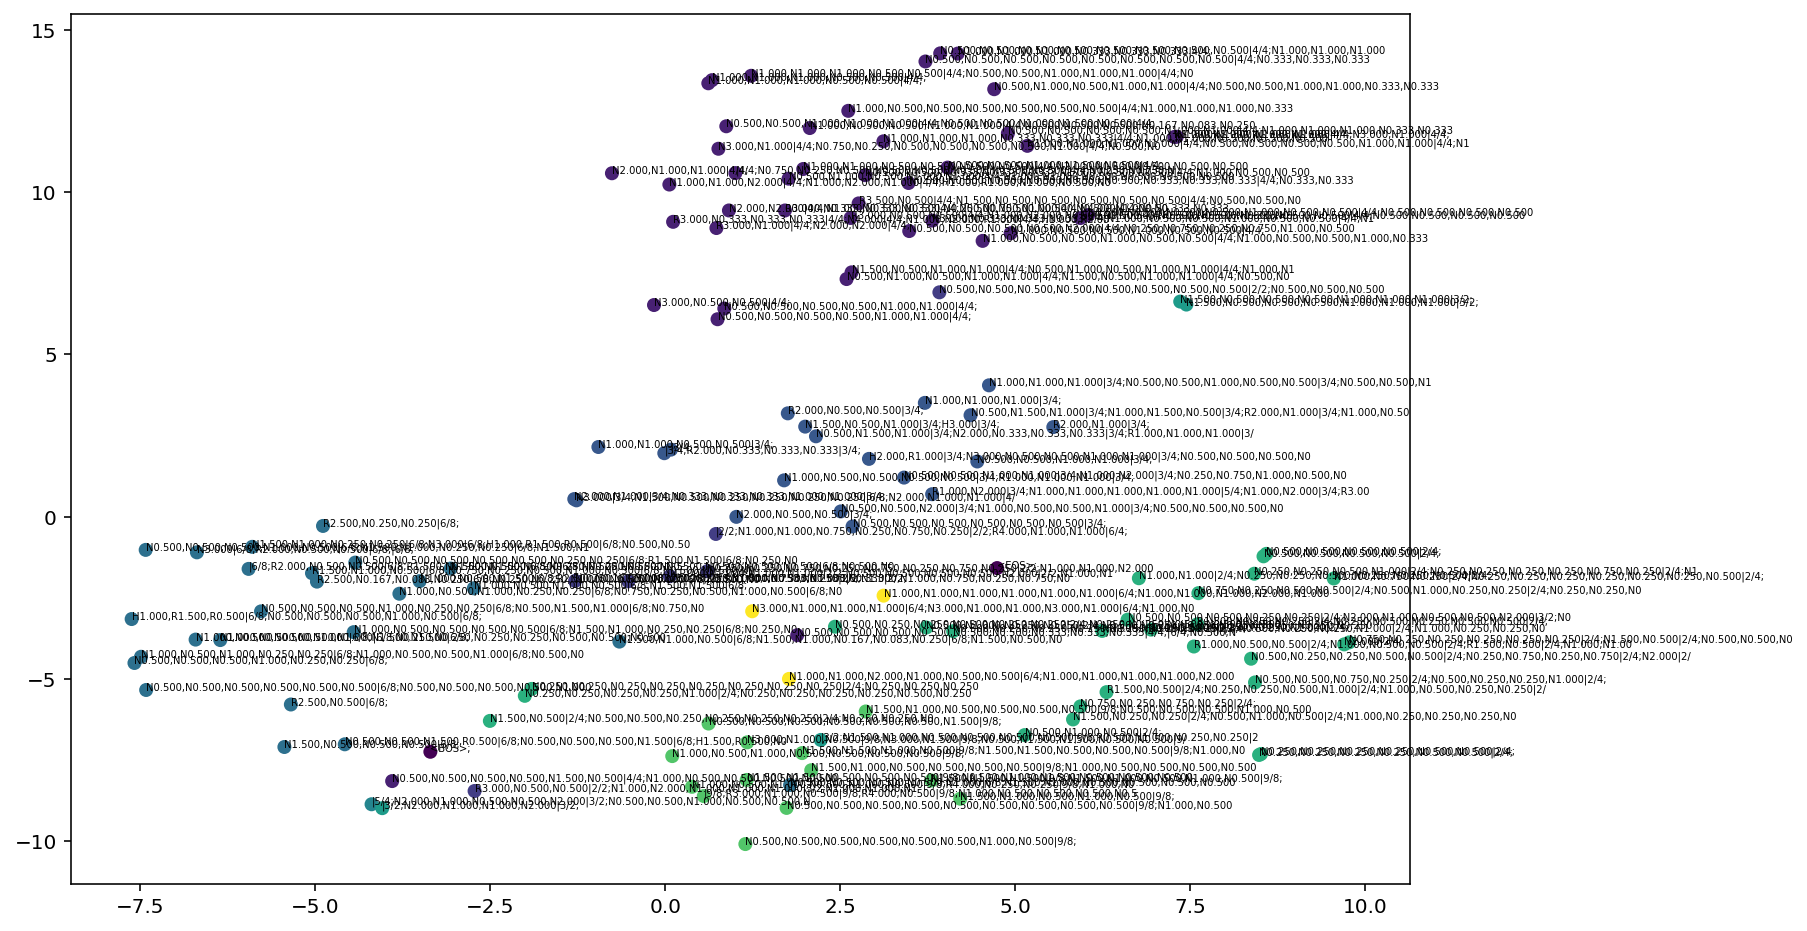

In [ ]:
vq_embedding_array = np.array(list(vq_emb_id_vocab.values()))
print(vq_embedding_array.shape)
X_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(vq_embedding_array)
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca()
class_list = list(vq_meter_vocab.values())
list_of_word_list = list(vq_word_vocab.values())
print(list_of_word_list)
class_array = np.array(class_list)
print(class_array.shape)
ax.scatter(X_tsne[:,0],X_tsne[:,1],c=class_list) #, c=class_array
for i in range(len(X_tsne)):
    x=X_tsne[i][0]
    y=X_tsne[i][1]
    string_tmp = ''
    for this_word_str in list_of_word_list[i]:
        string_tmp += this_word_str+';'
    #string_tmp = rhythm_dataset.class_contents_int2class[class_list[i]]
    if len(string_tmp)>80:
        string_tmp = string_tmp[0:80]
    ax.text(x , y , string_tmp ,size = 5)

plt.show()

### find similar words

In [ ]:
vq_list_str = list(vq_meter_vocab)
for i,k in enumerate(vq_list_str):
    vq_list_str[i] = str(k)
gensim_posttrain_model = gensim.models.Word2Vec([vq_list_str], size=config.emb_dim, window=10, min_count=1, workers=4)
for word in vq_meter_vocab:
    weight_update = vq_emb_id_vocab[word]
    gensim_posttrain_model.wv.add(str(word), weight_update, replace=True)

In [ ]:
random_id = int(random.random()*len(vq_list_str))
root_word = vq_list_str[random_id]
similar_list = gensim_posttrain_model.wv.most_similar(root_word)
####
root_meter = rhythm_dataset.class_contents_int2class[vq_meter_vocab[int(root_word)]]
print(root_meter)
for adj in similar_list:
    this_meter_str = rhythm_dataset.class_contents_int2class[vq_meter_vocab[int(adj[0])]]
    this_proxy_value = adj[1]
    print(this_meter_str,this_proxy_value)

2/4
2/4 0.9440737962722778
2/4 0.8848398923873901
2/4 0.7202877998352051
6/4 0.71940678358078
2/4 0.6997557878494263
2/4 0.68580162525177
2/4 0.6792349815368652
6/4 0.6764663457870483
2/4 0.6711336374282837
2/4 0.6540699005126953


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Analogy experiments

In [ ]:
config.mask_prob = 0
analogy_rhythm_dataset = RhythmDataset(config, 'rhythm_pattern_list_all.data', pad=False)
rhythm_loader4analogy = data.DataLoader(analogy_rhythm_dataset, batch_size=config.batch_size, shuffle=False)
rhythm_iter4analogy = infinite_iter(rhythm_loader4analogy)

max index in dict is  470
rhythm_pattern_list_all.data dataset size: 1019


In [ ]:
#data_package_analogy_root = rhythm_loader4analogy
for i,package in enumerate(rhythm_loader4analogy):
    if i == 0:
        data_package_analogy_root = package
    if i == 10:
        data_package_analogy_target = package

len_analogy_root = data_package_analogy_root['sentence_idx'].shape[1]
input_len_analogy_root = torch.LongTensor([[len_analogy_root]]).to(device)
print('The data as source (want to change 6/8 to 4/4)')
print(tokens2sentence(data_package_analogy_root['sentence_idx'],analogy_rhythm_dataset.int2word))
print(len_analogy_root)

len_analogy_target = data_package_analogy_target['sentence_idx'].shape[1]
input_len_analogy_target = torch.LongTensor([[len_analogy_target]]).to(device)
print('This is 4/4 target data')
print(tokens2sentence(data_package_analogy_target['sentence_idx'],analogy_rhythm_dataset.int2word))
print(len_analogy_target)


The data as source (want to change 6/8 to 4/4)
[['<BOS>', '|6/8', 'R2.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N1.500,N1.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N1.500,N1.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8', 'N0.500,N0.500,N0.500,N0.500,N0.500,N0

In [ ]:
output_package_analogy_root = loaded_VQRhythmModel.MLM_predict(data_package_analogy_root['sentence_idx'],
                                            data_package_analogy_root['sentence_meter'],
                                            input_len_analogy_root,var_factor=0.00)
output_package_analogy_target = loaded_VQRhythmModel.MLM_predict(data_package_analogy_target['sentence_idx'],
                                            data_package_analogy_target['sentence_meter'],
                                            input_len_analogy_target,var_factor=0.00)

In [ ]:
analogy_root_zq = output_package_analogy_root['zq'].clone()
analogy_root_zq_splitted = loaded_VQRhythmModel.splitter(analogy_root_zq)

analogy_target_zq = output_package_analogy_target['zq'].clone()
analogy_target_zq_splitted = loaded_VQRhythmModel.splitter(analogy_target_zq)

# target meter (4/4) -> root meter (6/8)
for t in range(1,len_analogy_target-1):
    analogy_root_zq_head1 = analogy_root_zq_splitted[0][:,t,:]
    analogy_root_zq_head2 = analogy_root_zq_splitted[1][:,t,:]
    #analogy_root_zq_head3 = analogy_root_zq_splitted[2][:,t,:]
    analogy_target_zq_splitted[0][:,t,:] = analogy_root_zq_head1
    analogy_target_zq_splitted[1][:,t,:] = analogy_root_zq_head2
    #analogy_target_zq_splitted[2][:,t,:] = analogy_root_zq_head3

analogy_target_zq_detached = torch.cat((analogy_target_zq_splitted[0].detach(),
                                        analogy_target_zq_splitted[1].detach(),
                                        analogy_target_zq_splitted[2]),dim=2)

zq_analogy, encoding_indices_analogy, loss_vq_analogy, perplexity_vq_analogy = \
loaded_VQRhythmModel.vq_encoder.quantizer(analogy_target_zq_detached)

zq_analogy += torch.randn(zq_analogy.shape).to(device)*0.08

analogy_output_logit = loaded_VQRhythmModel.classifier_pred(zq_analogy)
analogy_output_idx = torch.argmax(analogy_output_logit,dim=2)

print('-------------------------')
pred_str_result = tokens2sentence(analogy_output_idx, analogy_rhythm_dataset.int2word)[0]
for ele in pred_str_result:
    print(ele)

-------------------------
<BOS>
|4/4
N1.000,N1.000,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N1.000,N1.000,N1.000,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|4/4


In [ ]:
analogy_root_zq = output_package_analogy_root['zq']
analogy_root_zq_splitted = loaded_VQRhythmModel.splitter(analogy_root_zq)

analogy_target_zq = output_package_analogy_target['zq']
analogy_target_zq_splitted = loaded_VQRhythmModel.splitter(analogy_target_zq)

for t in range(1,len_analogy_target-1):
    analogy_target_zq_head1 = analogy_target_zq_splitted[0][:,t,:]
    analogy_target_zq_head2 = analogy_target_zq_splitted[1][:,t,:]
    analogy_root_zq_splitted[0][:,t,:] = analogy_target_zq_head1
    analogy_root_zq_splitted[1][:,t,:] = analogy_target_zq_head2

analogy_root_zq_detached = torch.cat((analogy_root_zq_splitted[0].detach(),
                                        analogy_root_zq_splitted[1].detach(),
                                        analogy_root_zq_splitted[2]),dim=2)

zq_analogy, encoding_indices_analogy, loss_vq_analogy, perplexity_vq_analogy = \
loaded_VQRhythmModel.vq_encoder.quantizer(analogy_root_zq_detached)

zq_analogy += torch.randn(zq_analogy.shape).to(device)*0.5

analogy_output_logit2 = loaded_VQRhythmModel.classifier_pred(zq_analogy)
analogy_output_idx2 = torch.argmax(analogy_output_logit2,dim=2)

print('-------------------------')
pred_str_result = tokens2sentence(analogy_output_idx2, analogy_rhythm_dataset.int2word)[0]
for ele in pred_str_result:
    print(ele)

-------------------------
<BOS>
|6/8
R2.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N1.500,N1.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N1.500,N1.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8
N0.500,N0.500,N0.500,N0.500,N0.500,

### writing reconstructions to midi

In [ ]:
rhythm_loader4tsne = data.DataLoader(rhythm_dataset, batch_size=config.batch_size, shuffle=False)
result_tuple_list = []
vocab_bias = 0
for input_package in rhythm_loader4tsne:
    this_len = input_package['sentence_idx'].shape[1]
    input_len = torch.LongTensor([[this_len]]).to(device)
    output_package = loaded_VQRhythmModel.MLM_predict(input_package['sentence_idx'],
                                         input_package['sentence_meter'],
                                         input_len)
    
    output_logit_pred = output_package['output_pred']
    output_pred = torch.argmax(output_logit_pred,dim=2)
    preds_word = tokens2sentence(output_pred, rhythm_loader4tsne.dataset.int2word)
    targets_word = tokens2sentence(input_package['target'], rhythm_loader4tsne.dataset.int2word)
    result_tuple_list.append((preds_word[0],targets_word[0]))

In [ ]:
result_tuple_list[0]

(['<BOS>',
  'N0.500,N0.500,N0.500,N1.000,N0.500|6/8',
  'R2.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N1.500,N1.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N1.500,N1.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500,N0.500,N0.500,N0.500,N0.500,N0.500|6/8',
  'N0.500

In [ ]:
midi_results_path = '/content/drive/My Drive/Colab Notebooks/music_GAN_rhythm_seed/model_VQ_VAE/midi_reconstructions' #Please change the path for your environment
result_tuplelist_to_midi(result_tuple_list,midi_results_path)
# There is a tiny bug in midi2word (wrong word N3.000,N1.000,N1.000,N3.000,N1.000|6/4). I will fix this bug soon...
# The midi2word library are Nottingham_database_preprocessor.py and Nottingham_database_preprocessor_util.py

Writing midi file number 0
Writing midi file number 1
Writing midi file number 2
Writing midi file number 3
Writing midi file number 4
Writing midi file number 5
Writing midi file number 6
Writing midi file number 7
Writing midi file number 8
Writing midi file number 9
Writing midi file number 10
Writing midi file number 11
Writing midi file number 12
Writing midi file number 13
Writing midi file number 14
Writing midi file number 15
Writing midi file number 16
Writing midi file number 17
Writing midi file number 18
Writing midi file number 19
Writing midi file number 20
Writing midi file number 21
Writing midi file number 22
Writing midi file number 23
Writing midi file number 24
Writing midi file number 25
Writing midi file number 26
Writing midi file number 27
Writing midi file number 28
Writing midi file number 29
Writing midi file number 30
Writing midi file number 31
Writing midi file number 32
Writing midi file number 33
Writing midi file number 34
Writing midi file number 35
Wr

AssertionError: ignored